<a href="https://colab.research.google.com/github/Michele-Maestrini/FusionCore/blob/main/01_EDA_Diagnostics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FusionCore v0 — EDA 01: Deep-Dive Diagnostic Audit (FD00x)

**Status:** `Research Grade`

**Author:** Michele Maestrini

## (1) Executive Objective & Domain Context
This notebook performs a **forensic audit** of the CMAPSS FD00x datasets. Unlike standard EDAs that focus on "data shape," this audit diagnoses **structural risk factors** for predictive modelling:
1.  **Regime Geometry:** Visualising the 3D operating space to detect manifold disjoints.
2.  **Signal Physics:** Quantifying Signal-to-Noise Ratio (SNR) and Stationarity to justify architecture (TFT vs TSMixer).
3.  **Failure Modes:** Mapping sensor correlations (Pearson vs Spearman) to specific physical degradation paths (HPC vs Fan).


**Output**: A set of "Go/No-Go" constraints for the Feature Engineering pipeline.

---

### Risk Questions Addressed

This notebook explicitly investigates the following structural risks:

- **Trajectory Consistency:** How consistent are degradation trajectories across engines? (Do they all fail the same way?)
- **Sensor Stability:** Which sensors exhibit instability, near-constant behaviour, or non-monotonic patterns that would confuse a linear model?
- **Signal Latency:** How early do degradation signals emerge relative to end-of-life? (The "Cold Start" problem).
- **Distribution Shift:** Are there distribution shifts across FD001–FD004 that threaten model generalisation?

**Impact:** Outputs from this analysis define the **architectural constraints** (e.g., need for Attention mechanisms vs MLPs) for the Benchmarking Phase.

---

### Commercial Modular Aero-Propulsion System Simulation (CMAPSS)
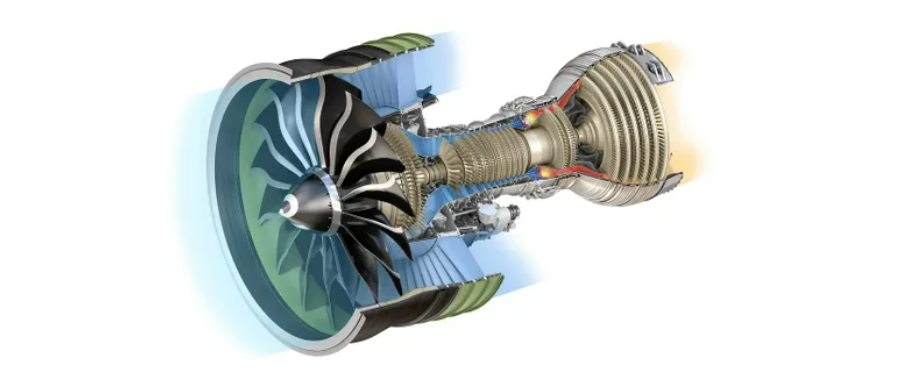

---

### Turbofan Engine Degradation

Each `FD00x` dataset contains multiple multivariate time series (one per engine). Each row represents one operational cycle.

### Column Schema

The raw text files contain **26 numeric columns**:

- **1** engine identifier (`unit_id`)
- **1** time index in cycles (`cycle`)
- **3** operating settings (`op_setting_1` ... `op_setting_3`)
- **21** sensor measurements (`sensor_1` ... `sensor_21`)

$$26 = 1 + 1 + 3 + 21$$

### Train vs. Test Structure

- **Train:** Each engine is observed from an initial healthy state until **failure**.
- **Test:** Each engine trajectory is **right-censored** (it ends some cycles *before* failure).
- **RUL Files:** Provide a vector of true remaining useful life values for the **final cycle** of each test engine.

### FD00x Dataset Properties

| Dataset | Train Units | Test Units | Operating Regimes | Fault Modes |
|---|---:|---:|---:|---:|
| **FD001** | 100 | 100 | 1 (Sea Level) | 1 (HPC Degradation) |
| **FD002** | 260 | 259 | 6 (Variable) | 1 (HPC Degradation) |
| **FD003** | 100 | 100 | 1 (Sea Level) | 2 (HPC, Fan) |
| **FD004** | 248 | 249 | 6 (Variable) | 2 (HPC, Fan) |

*Note: HPC = High-Pressure Compressor.*

### Objective function

Given the observed history of an engine up to cycle $t$, predict its remaining useful life (RUL):

$$\mathrm{RUL}(t) = T_{\text{fail}} - t$$

where $T_{\text{fail}}$ is the (unknown) failure cycle for that engine.

> **[Reference](https://ieeexplore.ieee.org/document/4711414):** A. Saxena, K. Goebel, D. Simon, and N. Eklund, *"Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"*, PHM 2008.
---
## **Training Units (The Statistical Sample)**

A "Unit" refers to a **distinct engine** (an independent run-to-failure trajectory).

### Mathematical Definition

Let:
* $i$ = engine (unit) index
* $t$ = cycle (time index)
* $x_{i}(t) \in \mathbb{R}^{d}$ = sensor vector for engine $i$ at cycle $t$

A **Training Unit** is the full sequence matrix:
$$
\mathbf{X}_i = \{x_i(1), x_i(2), \ldots, x_i(T_i)\}
$$
where $T_i$ is the failure cycle of engine $i$.

---

### The Independence Assumption (Critical)

* The **Unit** is the independent statistical sample.
* Rows (cycles) within a unit are **temporally dependent**.
* **Implication:** We must assume independence **across units**, not across rows.

> **⚠️ Engineering Constraint:** When splitting data for Train/Validation, we must split by `unit_id`. Randomly shuffling rows would cause **Data Leakage**, as the model would learn the specific degradation bias of an engine from the future.

---

### Data Structure Example

| Column | Meaning | Context |
| :--- | :--- | :--- |
| `unit_id` | Engine Identifier | The Independent Entity |
| `cycle` | Time Index | Dependent Step |
| `s_2` | LPC Temperature | Feature |
| `RUL` | Target | $T_{fail} - t$ |

**Example:**
* `unit_id = 17`
* `cycle = 1 ... 192`
* $\rightarrow$ **1 Training Unit**, **192 Dependent Rows**



### Libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
from google.colab import drive

# Advanced Math & Stats
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import pearsonr, spearmanr

# Ignore harmless warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# --- DRIVE MOUNTING ---
drive.mount('/content/drive')

# Define the Project Path
DATA_PATH = "/content/drive/MyDrive/PI/Datasets"

# Check if path exists to prevent errors later
if os.path.exists(DATA_PATH):
    print(f"✅ Connection Successful. Data path set to: {DATA_PATH}")
else:
    print(f"❌ Error: Path not found at {DATA_PATH}. Please check your directory structure.")

Mounted at /content/drive
✅ Connection Successful. Data path set to: /content/drive/MyDrive/PI/Datasets


### Environment Setup

In [ ]:
# --- SETUP ---

# Plotting Style - "Publication Quality"
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 120

## (2) Data Ingestion & Schema Audit

We load the four sub-datasets (FD001–FD004) to establish the baseline schema.
* **FD001:** Simple (Sea Level), Single Fault (HPC).
* **FD002:** Complex (6 Regimes), Single Fault (HPC).
* **FD003:** Simple (Sea Level), Multi-Fault (HPC + Fan).
* **FD004:** Complex (6 Regimes), Multi-Fault (HPC + Fan).

### Domain Knowledge Mapping
Before analyzing the data, we map the anonymised "Sensor X" to its physical component. This allows us to interpret *why* a correlation exists.

| Sensor ID | Physical Name | Description | Units | Failure Mode Link |
| :--- | :--- | :--- | :--- | :--- |
| **s_1** | T2_Total | Total Temp at Fan Inlet | °R | *Env/Constant* |
| **s_2** | T24_Total | Total Temp at LPC Outlet | °R | **Fan/LPC Degradation** |
| **s_3** | T30_Total | Total Temp at HPC Outlet | °R | **HPC Efficiency Loss** |
| **s_4** | T50_Total | Total Temp at LPT Outlet (EGT) | °R | **Overall Engine Health (Critical)** |
| **s_5** | P2_Pressure | Pressure at Fan Inlet | psia | *Env/Constant* |
| **s_6** | P15_Total | Total Pressure in Bypass Duct | psia | **Fan Efficiency Loss** |
| **s_7** | P30_Total | Total Pressure at HPC Outlet | psia | **HPC Compression Ratio Loss** |
| **s_8** | Nf_Physical | Physical Fan Speed | rpm | **Fan/Shaft Imbalance** |
| **s_9** | Nc_Physical | Physical Core Speed | rpm | **Core/HPC Speed Shifts** |
| **s_10** | ef_Static | Static Pressure at HPC Outlet | psia | *Usually Constant* |
| **s_11** | P50_Total | Ratio of Fuel Flow to Ps30 | - | **Combustor/Fuel System Issues** |
| **s_12** | Phi | Corrected Fan Speed | rpm | **Fan Aerodynamics** |
| **s_13** | NRf | Corrected Core Speed | rpm | **HPC Aerodynamics** |
| **s_14** | NRc | Bypass Ratio | - | **Flow Divergence (Fan vs Core)** |
| **s_15** | BPR | Burner Fuel-Air Ratio | - | **Combustion Efficiency** |
| **s_16** | farB | Bleed Enthalpy | - | *Secondary System* |
| **s_17** | htBleed | Demanded Fan Speed | rpm | *Control Signal (Not a failure)* |
| **s_18** | Nf_dmd | Demanded Corrected Fan Speed | rpm | *Control Signal* |
| **s_19** | PCNfR_dmd | HPT Coolant Bleed | lbm/s | *Thermal Management* |
| **s_20** | W31 | LPT Coolant Bleed | lbm/s | *Thermal Management* |
| **s_21** | W32 | LPT Coolant Bleed | lbm/s | *Thermal Management* |

In [ ]:
# --- 2. DATA INGESTION & SCHEMA VALIDATION ---

# Column Definitions
cols = ['unit_id', 'time_cycle', 'setting_1', 'setting_2', 'setting_3'] + [f's_{i}' for i in range(1, 22)]

def load_and_preview_data(base_path):
    datasets = {}
    file_list = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']

    print(f"📂 Loading Datasets from {base_path}...\n")

    for fname in file_list:
        fpath = os.path.join(base_path, fname)
        if os.path.exists(fpath):
            dataset_name = fname.split('_')[1].split('.')[0] # e.g., FD001

            # Load
            df = pd.read_csv(fpath, sep=r'\s+', header=None, names=cols)

            # Feature Engineering: RUL Calculation (Critical for EDA)
            # RUL = Max_Cycle - Current_Cycle
            max_life = df.groupby('unit_id')['time_cycle'].max().rename('max_life')
            df = df.merge(max_life, on='unit_id')
            df['RUL'] = df['max_life'] - df['time_cycle']

            datasets[dataset_name] = df

            # --- THE PREVIEW TABLE ---
            print(f"🔹 {dataset_name} | Shape: {df.shape} | Engines: {df['unit_id'].nunique()}")
            display(df.head(3)) # Displays the dataframe table nicely in Colab
            print("-" * 80)

        else:
            print(f"⚠️ Missing File: {fname}")

    return datasets

# Execute
data_dict = load_and_preview_data(DATA_PATH)

📂 Loading Datasets from /content/drive/MyDrive/PI/Datasets...

🔹 FD001 | Shape: (20631, 28) | Engines: 100


,unit_id,time_cycle,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_life,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189


--------------------------------------------------------------------------------
🔹 FD002 | Shape: (53759, 28) | Engines: 260


,unit_id,time_cycle,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_life,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,149,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,149,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,149,146


--------------------------------------------------------------------------------
🔹 FD003 | Shape: (24720, 28) | Engines: 100


,unit_id,time_cycle,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_life,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,259,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,259,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,259,256


--------------------------------------------------------------------------------
🔹 FD004 | Shape: (61249, 28) | Engines: 249


,unit_id,time_cycle,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,max_life,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670,321,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552,321,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213,321,318


--------------------------------------------------------------------------------


## (3) Structural Audit: Lifecycles & Sensor Variance

We extend the diagnostic pipeline to the full FD00x suite. The objective is to quantify **distribution shift** and **complexity scaling** between the simple (FD001) and complex (FD004) environments.

### Key Audit Dimensions:
1.  **Population Scale:** Row/Engine counts and data integrity (nullity) checks.
2.  **Failure Horizon (Lifecycle):** Distribution of `max_cycles` per engine.
    * *Hypothesis:* Complex regimes (FD002/FD004) may exhibit higher variance in engine lifespan.
3.  **Signal Entropy:** Log-scale variance profiling.
    * *Objective:* Identify which sensors are "Dead" (Zero Variance) vs "Active" across datasets.
4.  **Target Balance:** RUL distribution analysis to ensure sufficient coverage of the "Critical Zone" (RUL < 50 cycles).

--- 🔍 Structural Audit Report ---


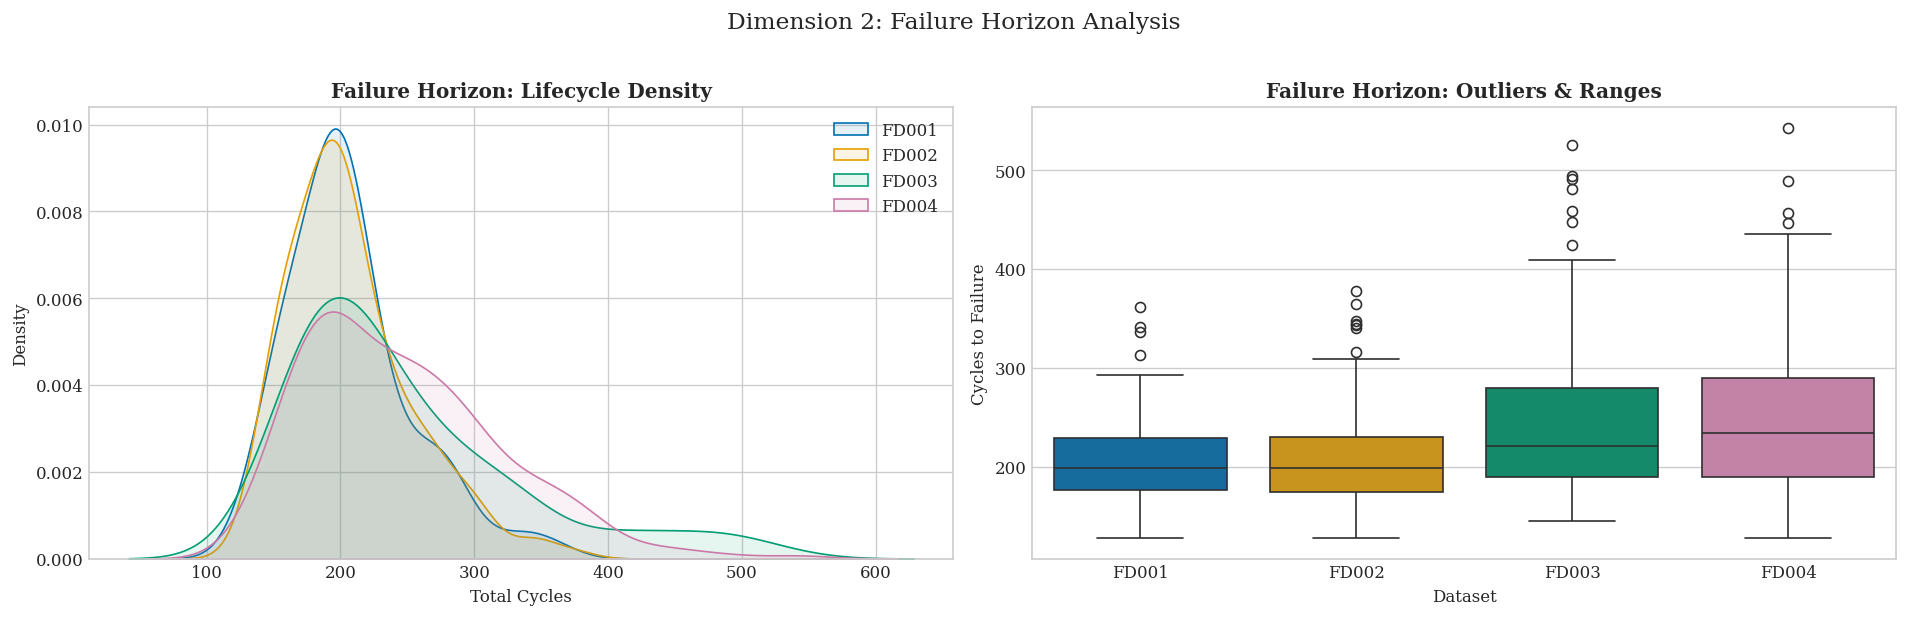

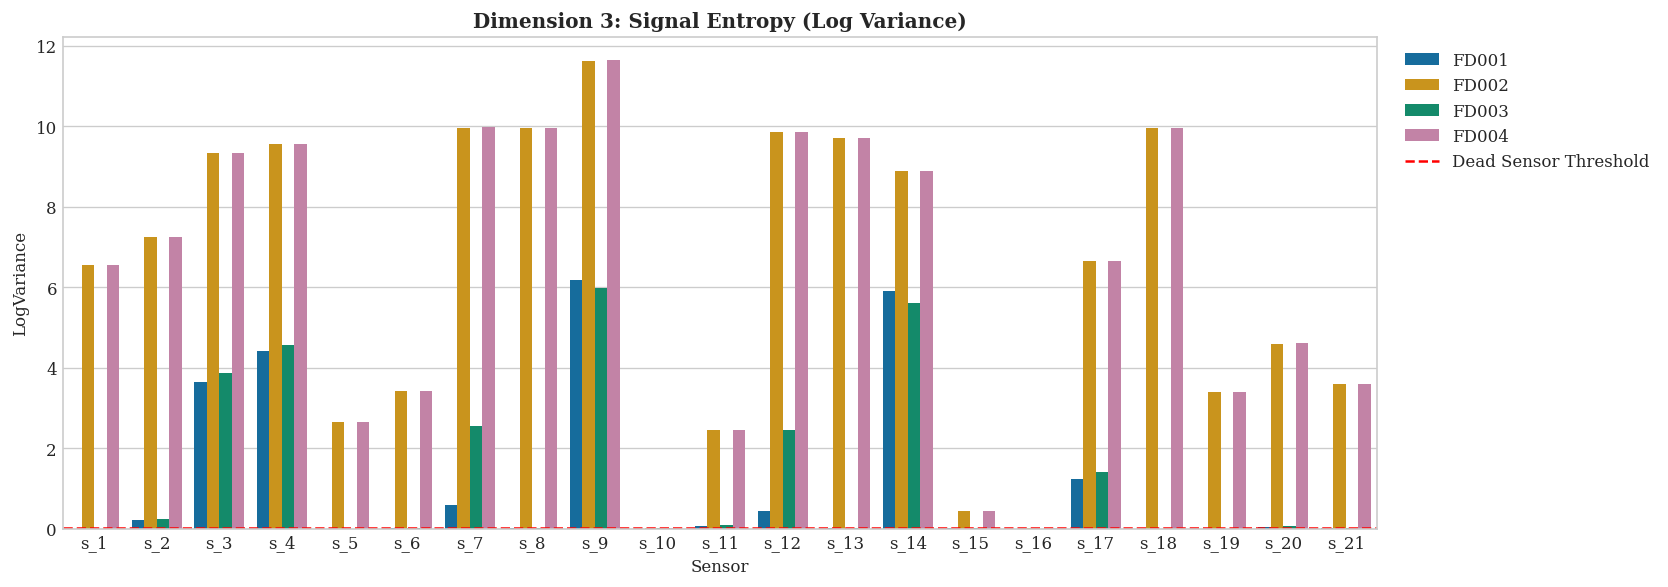

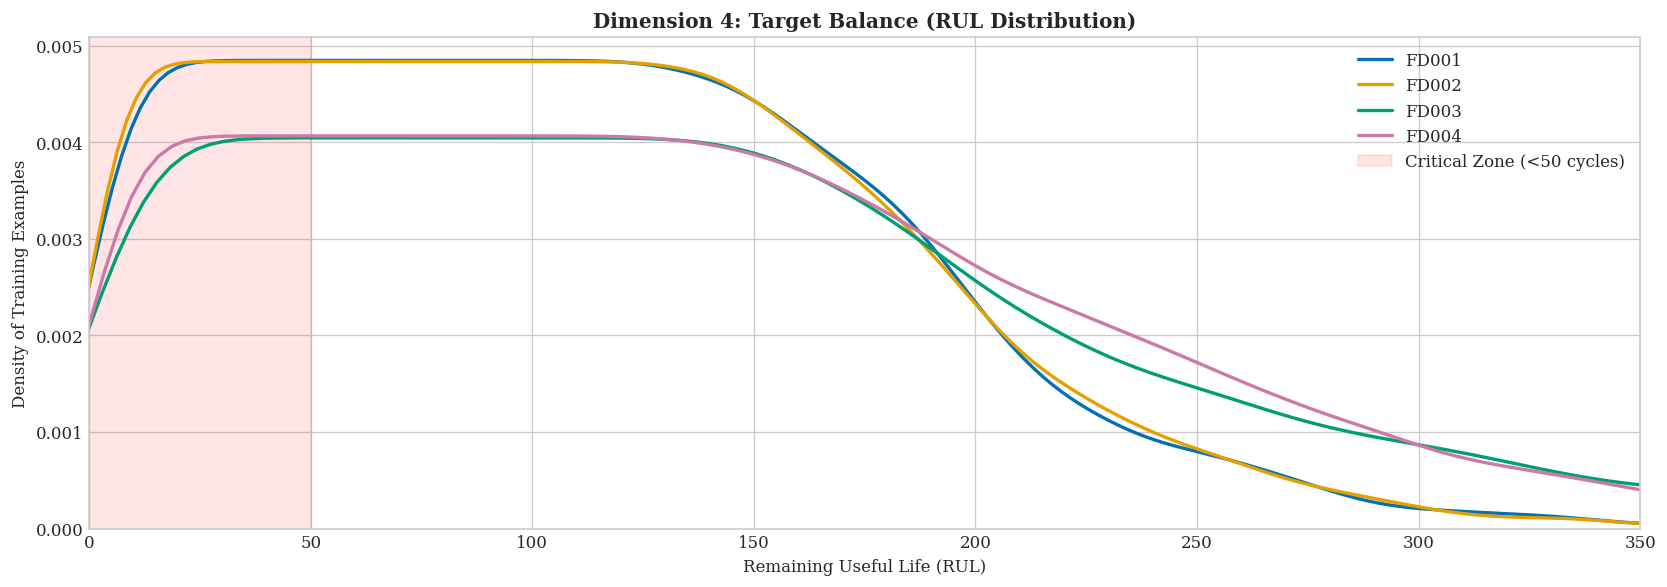


--- 📋 Dimension 1: Population Scale & Integrity ---


,Dataset,Engines,Total Rows,Dead Sensors,Critical Data (<50)
0,FD001,100,20631,"s_1, s_5, s_10, s_16, s_18, s_19",24.7%
1,FD002,260,53759,None,24.7%
2,FD003,100,24720,"s_1, s_5, s_16, s_18, s_19",20.6%
3,FD004,249,61249,None,20.7%


In [ ]:
# --- 3. STRUCTURAL AUDIT: LIFECYCLES, VARIANCE & TARGET BALANCE ---

FusionColours = {
    'FD001': '#0072B2', 'FD002': '#E69F00',
    'FD003': '#009E73', 'FD004': '#CC79A7'
}

def perform_structural_audit(data_dict):
    """
    Complete Structural Audit covering:
    1. Lifecycle Distribution (Survival)
    2. Sensor Variance (Entropy)
    3. Target Balance (RUL Distribution) - NEW
    """
    print("--- 🔍 Structural Audit Report ---")

    sensor_names = [f's_{i}' for i in range(1, 22)]

    # --- 1. LIFECYCLE ANALYSIS ---
    lifecycle_data = []
    for name, df in data_dict.items():
        max_lifes = df.groupby('unit_id')['max_life'].max()
        for life in max_lifes:
            lifecycle_data.append({'Dataset': name, 'Cycles to Failure': life})
    lifecycle_df = pd.DataFrame(lifecycle_data)

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # A. Density
    for name, df in data_dict.items():
        lifecycles = df.groupby('unit_id')['max_life'].max()
        sns.kdeplot(lifecycles, label=name, color=FusionColours.get(name), fill=True, alpha=0.1, ax=axes[0])
    axes[0].set_title('Failure Horizon: Lifecycle Density', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Total Cycles')
    axes[0].legend()

    # B. Box Plot
    sns.boxplot(data=lifecycle_df, x='Dataset', y='Cycles to Failure', palette=FusionColours, ax=axes[1])
    axes[1].set_title('Failure Horizon: Outliers & Ranges', fontsize=12, fontweight='bold')

    plt.suptitle("Dimension 2: Failure Horizon Analysis", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- 2. SIGNAL ENTROPY (VARIANCE) ---
    variance_data = []
    for name, df in data_dict.items():
        var_series = df[sensor_names].var()
        for sensor, val in var_series.items():
            variance_data.append({'Dataset': name, 'Sensor': sensor, 'LogVariance': np.log1p(val)})
    var_df = pd.DataFrame(variance_data)

    plt.figure(figsize=(14, 5))
    sns.barplot(data=var_df, x='Sensor', y='LogVariance', hue='Dataset', palette=FusionColours)
    plt.title('Dimension 3: Signal Entropy (Log Variance)', fontsize=12, fontweight='bold')
    plt.axhline(y=0.01, color='r', linestyle='--', label='Dead Sensor Threshold')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 3. TARGET BALANCE (RUL DISTRIBUTION) - NEW! ---
    # This specifically addresses "Target Balance" / "Critical Zone Coverage"
    plt.figure(figsize=(14, 5))
    for name, df in data_dict.items():
        # We plot the density of RUL values
        sns.kdeplot(df['RUL'], label=name, color=FusionColours.get(name), linewidth=2)

    plt.title('Dimension 4: Target Balance (RUL Distribution)', fontsize=12, fontweight='bold')
    plt.xlabel('Remaining Useful Life (RUL)')
    plt.ylabel('Density of Training Examples')

    # Highlight the "Critical Zone" (< 50 cycles)
    plt.axvspan(0, 50, color='red', alpha=0.1, label='Critical Zone (<50 cycles)')
    plt.xlim(0, 350) # Focus on the active range
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 4. SUMMARY TABLE ---
    summary_list = []
    for name, df in data_dict.items():
        lifecycles = df.groupby('unit_id')['max_life'].max()
        variances = df[sensor_names].var()
        dead_list = variances[variances < 1e-6].index.tolist()
        dead_str = ", ".join(dead_list) if dead_list else "None"

        # Calculate Critical Zone Coverage
        critical_count = df[df['RUL'] <= 50].shape[0]
        critical_ratio = (critical_count / df.shape[0]) * 100

        summary_list.append({
            'Dataset': name,
            'Engines': df['unit_id'].nunique(),
            'Total Rows': df.shape[0],
            'Dead Sensors': dead_str,
            'Critical Data (<50)': f"{critical_ratio:.1f}%" # New Metric
        })

    summary_df = pd.DataFrame(summary_list)
    print("\n--- 📋 Dimension 1: Population Scale & Integrity ---")
    display(summary_df.style.set_properties(**{'text-align': 'left'}))

if 'data_dict' in locals():
    perform_structural_audit(data_dict)

## (4) Signal Diagnostics: Stationarity & Regime Masking

This section addresses the "Black Box" architectural risks. We perform hypothesis testing to determine the necessary model complexity and normalization strategy.

### Stationarity Analysis (ADF Test)
* **Hypothesis:** If raw sensor data is non-stationary (mean/variance changes over time), simple MLPs may struggle without differencing.
* **Method:** Augmented Dickey-Fuller (ADF) test on critical sensors.
  * $p < 0.05$: Stationary (Memoryless signal).
  * $p > 0.05$: Non-Stationary (Trend/Memory exists $\rightarrow$ requires Sequence Models).

### A. Regime Masking Audit (Forensic Signal Reconstruction)
* **Hypothesis:** In complex datasets (FD002/FD004), operating conditions (Altitude/Mach) act as "Confounders" that mask the true degradation signal.
* **Method:** We perform a **"Green vs Blue" Forensic Audit**:
    * **Raw Signal (Green):** Shows the sensor reading masked by regime switching.
    * **De-Noised Signal (Blue):** Shows the same signal after subtracting the **Regime Mean** (tabulated below).
* **Goal:** To prove that the "noise" is deterministic and can be mathematically removed.

### B. Trajectory Consistency
* **Question:** Do all engines degrade along the same path?
* **Risk:** If trajectories are chaotic (inconsistent), we cannot use a simple "Time-to-Failure" regression. We must use models that track "Health State" (Hidden Markov / RNNs).

--- 🔬 Regime Masking Audit: Fleet-Wide Forensic Split-View (s_12) ---


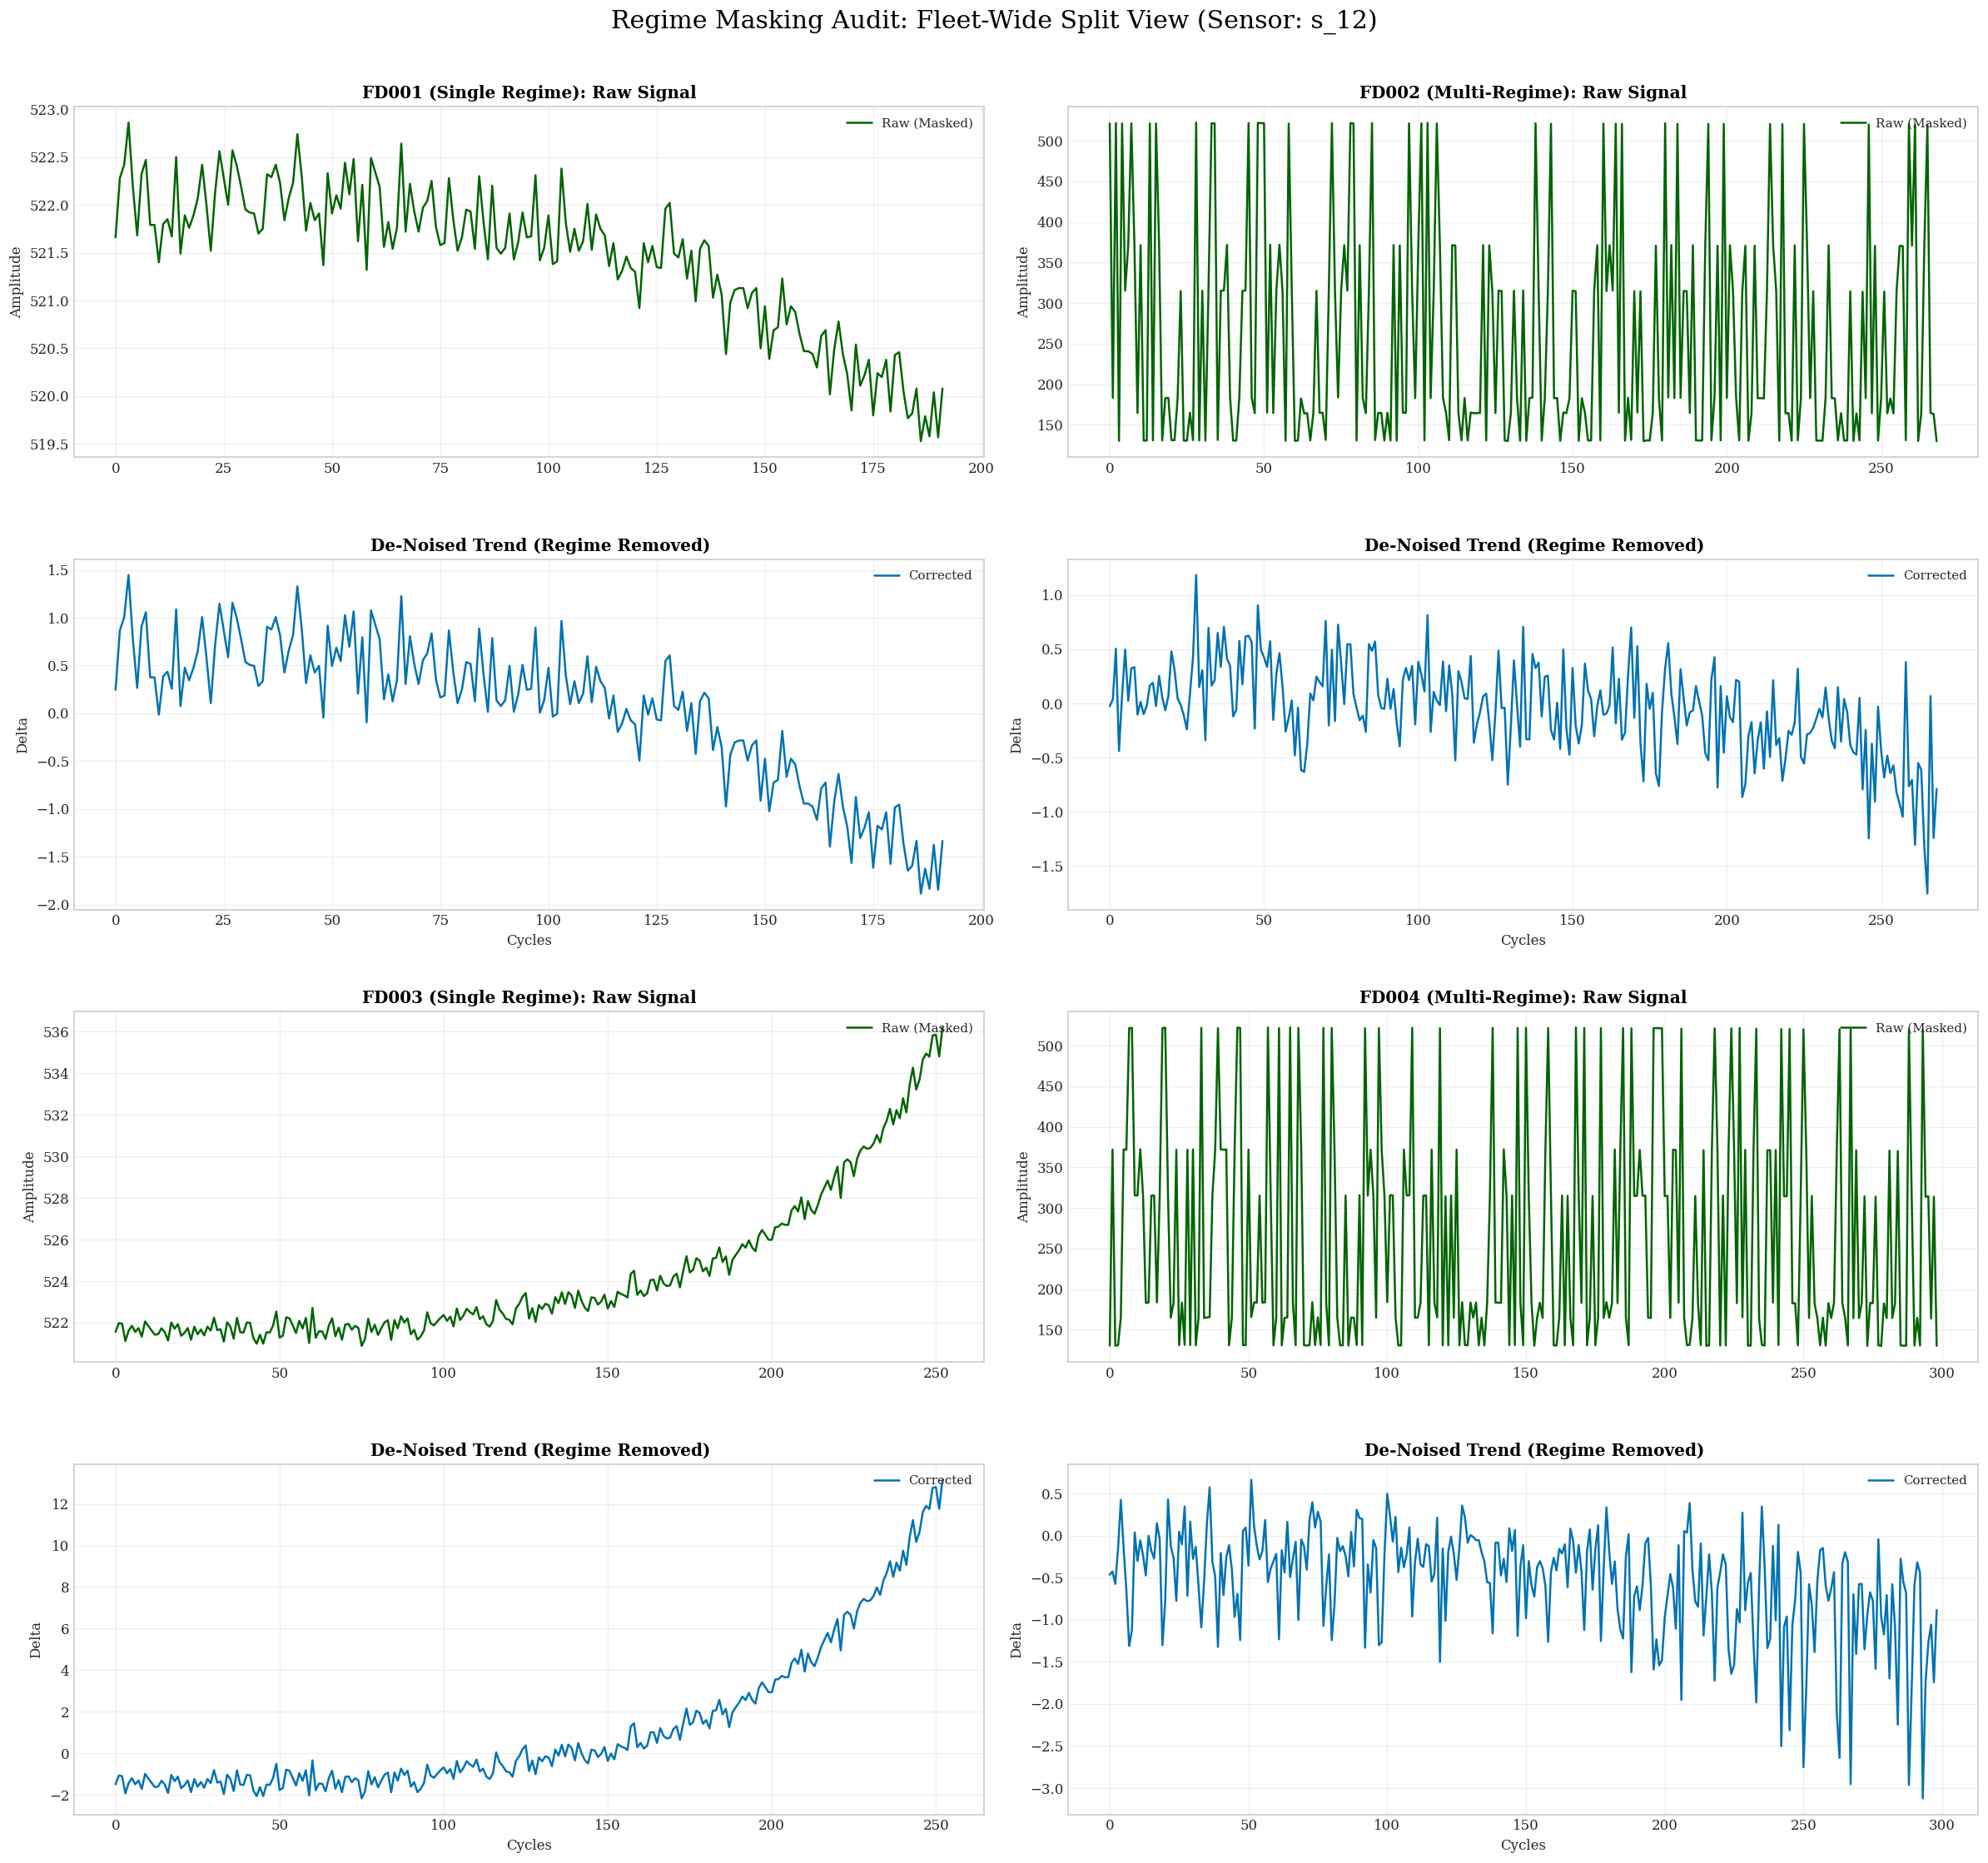


>>> REGIME MEANS REFERENCE TABLE (Values subtracted from Raw Signal):
    * Colour Intensity represents Magnitude (Darker Blue = Higher Value)


,Type,Regime 0,Regime 1,Regime 2,Regime 3,Regime 4,Regime 5
Dataset,,,,,,,
FD001,Single Regime,521.41,nan,nan,nan,nan,nan
FD002,Multi-Regime,130.55,314.87,164.57,521.40,371.45,183.02
FD003,Single Regime,523.05,nan,nan,nan,nan,nan
FD004,Multi-Regime,130.82,372.45,164.88,315.53,523.03,183.44


In [ ]:
# --- 4A. REGIME MANIFOLD RECONSTRUCTION ---

def prove_regime_normalization_all(data_dict, sensor='s_12'):
    """
    Forensic Proof: Shows the impact of Regime Normalization on Sensor 12 (Fan Speed).
    LAYOUT: 4 Rows x 2 Columns.
    - Top Half: FD001 (Left) vs FD002 (Right)
    - Bottom Half: FD003 (Left) vs FD004 (Right)
    COLOURS: Raw = Dark Green, Corrected = Blue.
    """
    print(f"--- 🔬 Regime Masking Audit: Fleet-Wide Forensic Split-View ({sensor}) ---")

    dataset_order = ['FD001', 'FD002', 'FD003', 'FD004']

    # 4 Rows, 2 Cols. Increased height for spacing.
    fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharex=False)

    # Store regime means for the final table
    table_data = []

    # Map dataset index to grid positions (Row, Col) for the RAW plot
    grid_map = {
        0: (0, 0), # FD001: Top-Left
        1: (0, 1), # FD002: Top-Right
        2: (2, 0), # FD003: Bottom-Left
        3: (2, 1)  # FD004: Bottom-Right
    }

    for i, name in enumerate(dataset_order):
        if name not in data_dict: continue

        df = data_dict[name].copy()

        # 1. Determine Regime Logic
        if name in ['FD001', 'FD003']:
            df['regime'] = 0
            n_clusters = 1
            desc = "Single Regime"
        else:
            settings = ['setting_1', 'setting_2', 'setting_3']
            kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
            df['regime'] = kmeans.fit_predict(df[settings])
            n_clusters = 6
            desc = "Multi-Regime"

        # 2. Select representative unit
        unit_id = 2 if name != 'FD001' else 1
        unit_data = df[df['unit_id'] == unit_id].copy().reset_index(drop=True)

        # 3. Calculate Regime Means
        regime_means = df.groupby('regime')[sensor].mean().sort_index()

        # Store for Table
        row = {'Dataset': name, 'Type': desc}
        for r in range(6):
            row[f'Regime {r}'] = regime_means.get(r, np.nan)
        table_data.append(row)

        # 4. De-Noise
        unit_data[f'{sensor}_corrected'] = unit_data.apply(
            lambda x: x[sensor] - regime_means[x['regime']], axis=1
        )

        # --- PLOT SETUP ---
        r, c = grid_map[i]
        ax_raw = axes[r, c]      # Top Plot (Raw)
        ax_corr = axes[r+1, c]   # Bottom Plot (Corrected)

        # PLOT A: Raw Signal (Dark Green)
        ax_raw.plot(unit_data.index, unit_data[sensor], color='#006400', linewidth=1.5, label='Raw (Masked)')
        ax_raw.set_title(f'{name} ({desc}): Raw Signal', fontweight='bold', color='black', fontsize=12)
        ax_raw.set_ylabel('Amplitude')
        ax_raw.grid(True, alpha=0.3)
        ax_raw.legend(loc='upper right', fontsize=9)

        # PLOT B: Corrected Signal (Blue)
        ax_corr.plot(unit_data.index, unit_data[f'{sensor}_corrected'], color='#0072B2', linewidth=1.5, label='Corrected')
        ax_corr.set_title(f'    De-Noised Trend (Regime Removed)', fontweight='bold', color='black', fontsize=12)
        ax_corr.set_ylabel('Delta')
        ax_corr.set_xlabel('Cycles')
        ax_corr.grid(True, alpha=0.3)
        ax_corr.legend(loc='upper right', fontsize=9)

        # [REMOVED] The visual separator line logic was here.

    plt.suptitle(f"Regime Masking Audit: Fleet-Wide Split View (Sensor: {sensor})", fontsize=18, y=0.96, color='black')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=3.0)
    plt.show()

    # --- SUMMARY TABLE ---
    print("\n>>> REGIME MEANS REFERENCE TABLE (Values subtracted from Raw Signal):")
    print("    * Colour Intensity represents Magnitude (Darker Blue = Higher Value)")
    means_df = pd.DataFrame(table_data).set_index('Dataset')
    display(means_df.style.format("{:.2f}", subset=[f'Regime {r}' for r in range(6)])
            .background_gradient(cmap='Blues', axis=1))

# Execute
if 'data_dict' in locals():
    prove_regime_normalization_all(data_dict, sensor='s_12')

--- 📈 Trajectory Consistency Check (Sensor: s_12) ---


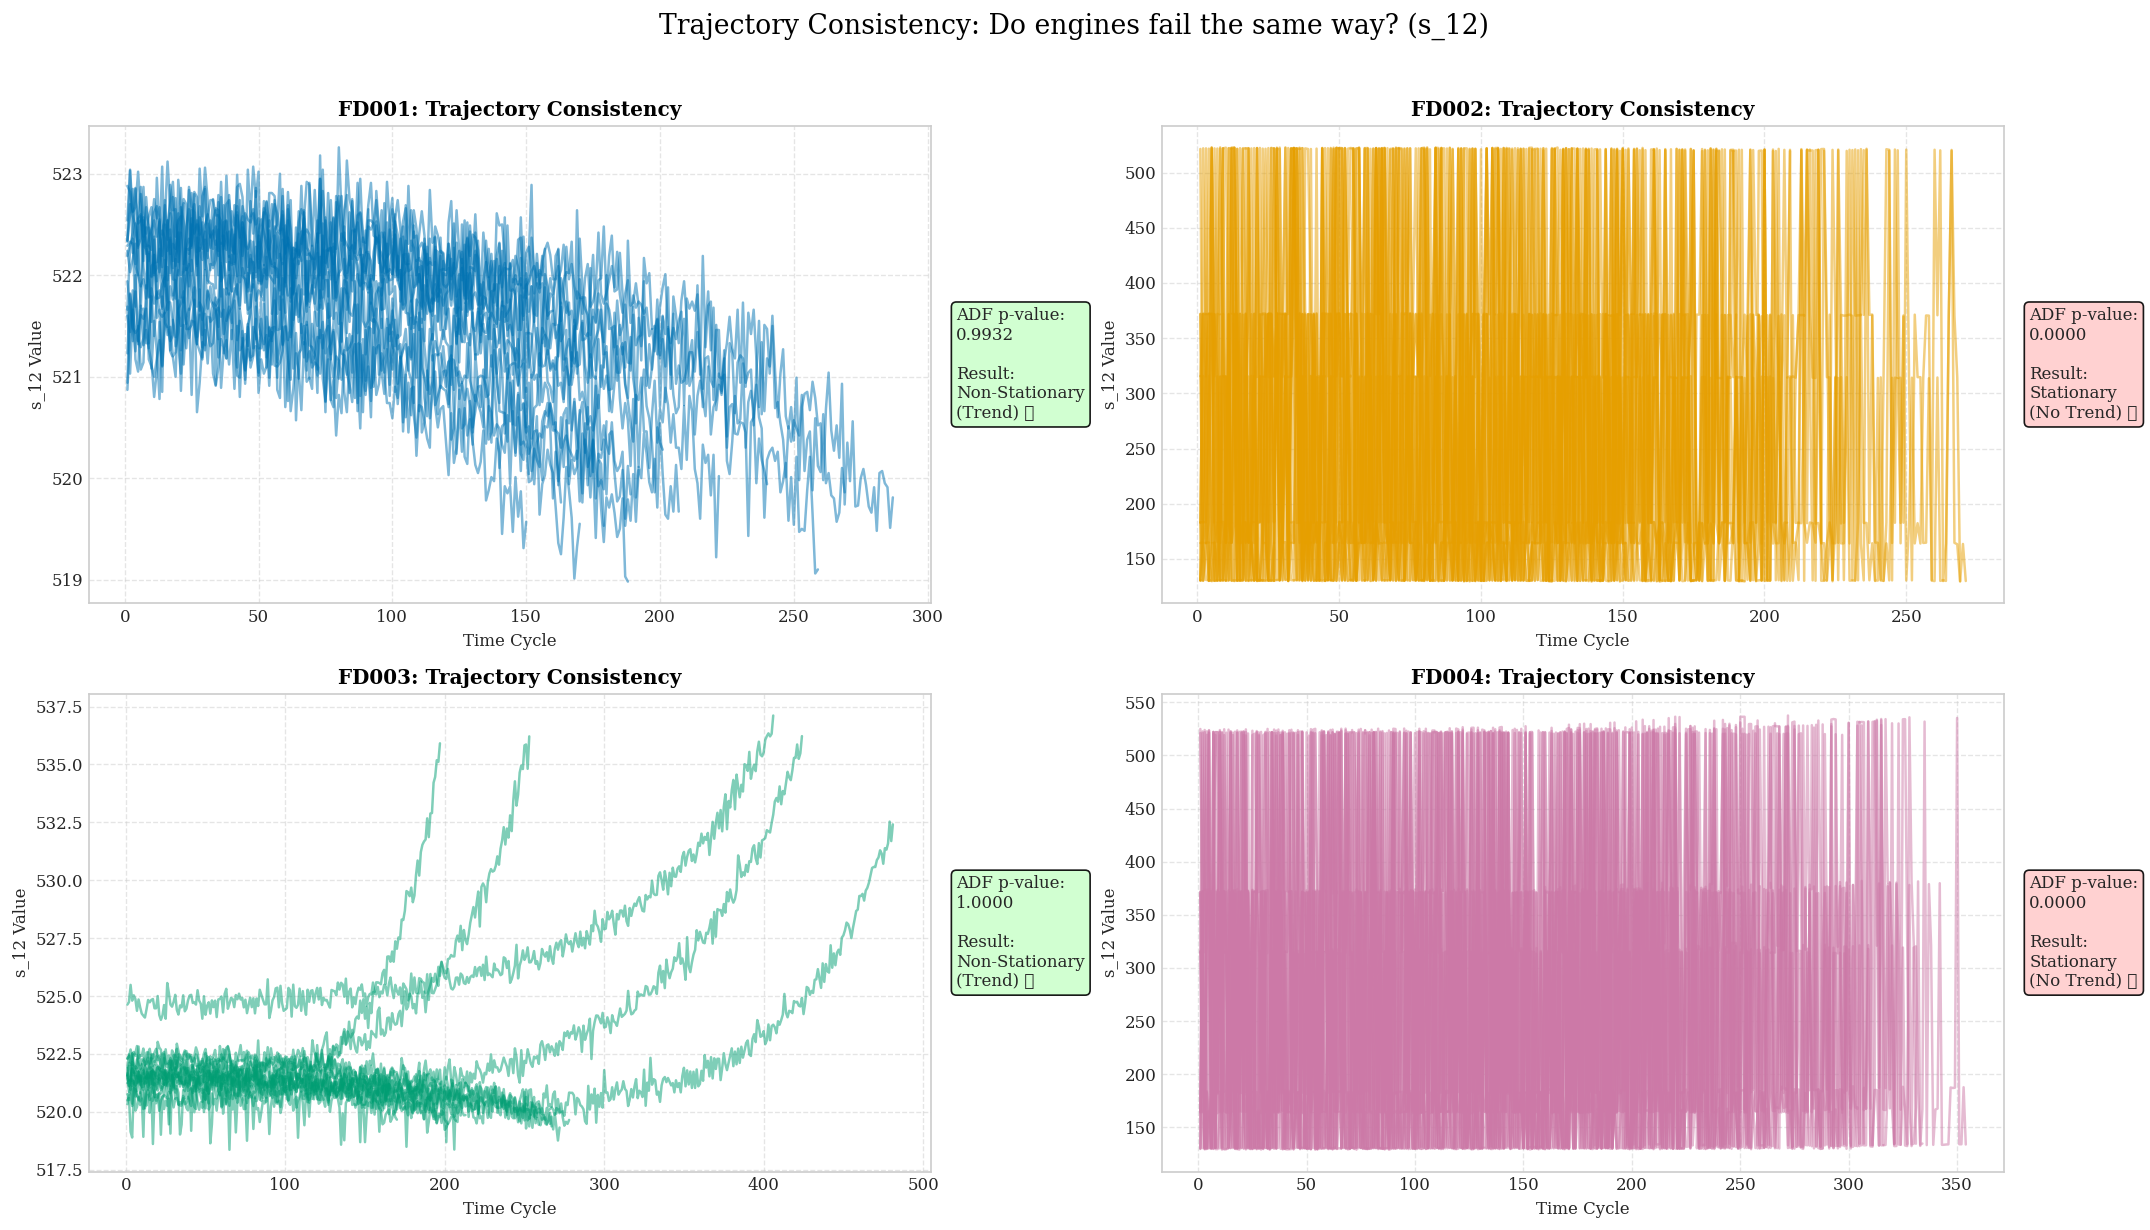

In [ ]:
# --- 4B. TRAJECTORY CONSISTENCY ANALYSIS (ADF & PATHS) ---

def analyze_degradation_consistency(data_dict, sensor_id='s_12'):
    """
    Visualises degradation paths across the fleet to check for consistency.
    Runs ADF Test to check for Stationarity (Trend presence).
    """
    print(f"--- 📈 Trajectory Consistency Check (Sensor: {sensor_id}) ---")

    FusionColours = {
        'FD001': '#0072B2', 'FD002': '#E69F00',
        'FD003': '#009E73', 'FD004': '#CC79A7'
    }

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()
    dataset_order = ['FD001', 'FD002', 'FD003', 'FD004']

    for i, name in enumerate(dataset_order):
        if name not in data_dict:
            axes[i].text(0.5, 0.5, 'Not Loaded', ha='center')
            continue

        df = data_dict[name]
        ax = axes[i]

        # 1. Visualise Paths
        sample_units = df['unit_id'].unique()[:15]
        color = FusionColours.get(name, 'gray')

        for unit in sample_units:
            subset = df[df['unit_id'] == unit]
            ax.plot(subset['time_cycle'], subset[sensor_id], color=color, alpha=0.5, linewidth=1.5)

        # TITLE: Black
        ax.set_title(f'{name}: Trajectory Consistency', fontweight='bold', color='black')
        ax.set_xlabel('Time Cycle')
        ax.set_ylabel(f'{sensor_id} Value')
        ax.grid(True, linestyle='--', alpha=0.5)

        # 2. ADF Stationarity Test
        unit_1_series = df[df['unit_id'] == 1][sensor_id]
        try:
            result = adfuller(unit_1_series)
            p_value = result[1]
            if p_value < 0.05:
                res_text = "Stationary\n(No Trend) ⚠️"
                bg_color = '#ffcccc'
            else:
                res_text = "Non-Stationary\n(Trend) ✅"
                bg_color = '#ccffcc'
            stats_text = f"ADF p-value:\n{p_value:.4f}\n\nResult:\n{res_text}"
        except:
            stats_text = "ADF Failed"
            bg_color = '#eeeeee'

        # Stats Box Outside
        ax.text(1.03, 0.5, stats_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor=bg_color, alpha=0.9))

    plt.suptitle(f"Trajectory Consistency: Do engines fail the same way? ({sensor_id})", fontsize=16, y=1.02, color='black')
    plt.tight_layout()
    plt.show()

# Execute
if 'data_dict' in locals():
    analyze_degradation_consistency(data_dict, sensor_id='s_12')

## (5) Signal Quality & Feature Selection Metrics

This section qualifies the *utility* of each sensor. We go beyond simple correlation to diagnose **Signal Integrity** and **Degradation Shape**.

### A. Signal-to-Noise Ratio (SNR)
We quantify the "cleanliness" of the degradation signal.
* **Method:** We decompose the signal into a **Trend** (Moving Average) and **Noise** (Residuals).
* **Formula:** $SNR = 10 \cdot \log_{10} \left( \frac{\text{Var}(\text{Trend})}{\text{Var}(\text{Noise})} \right)$ (measured in dB).
* **Impact:** Low SNR sensors (< 10dB) cannot be used for "Rate of Change" features as differentiation amplifies noise.

### B. Linearity Check (Pearson vs Spearman)
We compare two correlation coefficients to determine the *shape* of the degradation.
* **Pearson ($\rho$):** Measures **Linear** correlation.
* **Spearman ($r_s$):** Measures **Monotonic** (Rank) correlation.
* **Diagnosis:**
    * If $r_s \approx \rho$: Degradation is Linear.
    * If $|r_s| \gg |\rho|$: Degradation is **Non-Linear** (Exponential/Curved).
    * **Action:** Significant non-linearity confirms the need for Deep Learning (Non-linear activations) over simple Regression.

--- 📊 Comparative Signal Quality Audit ---


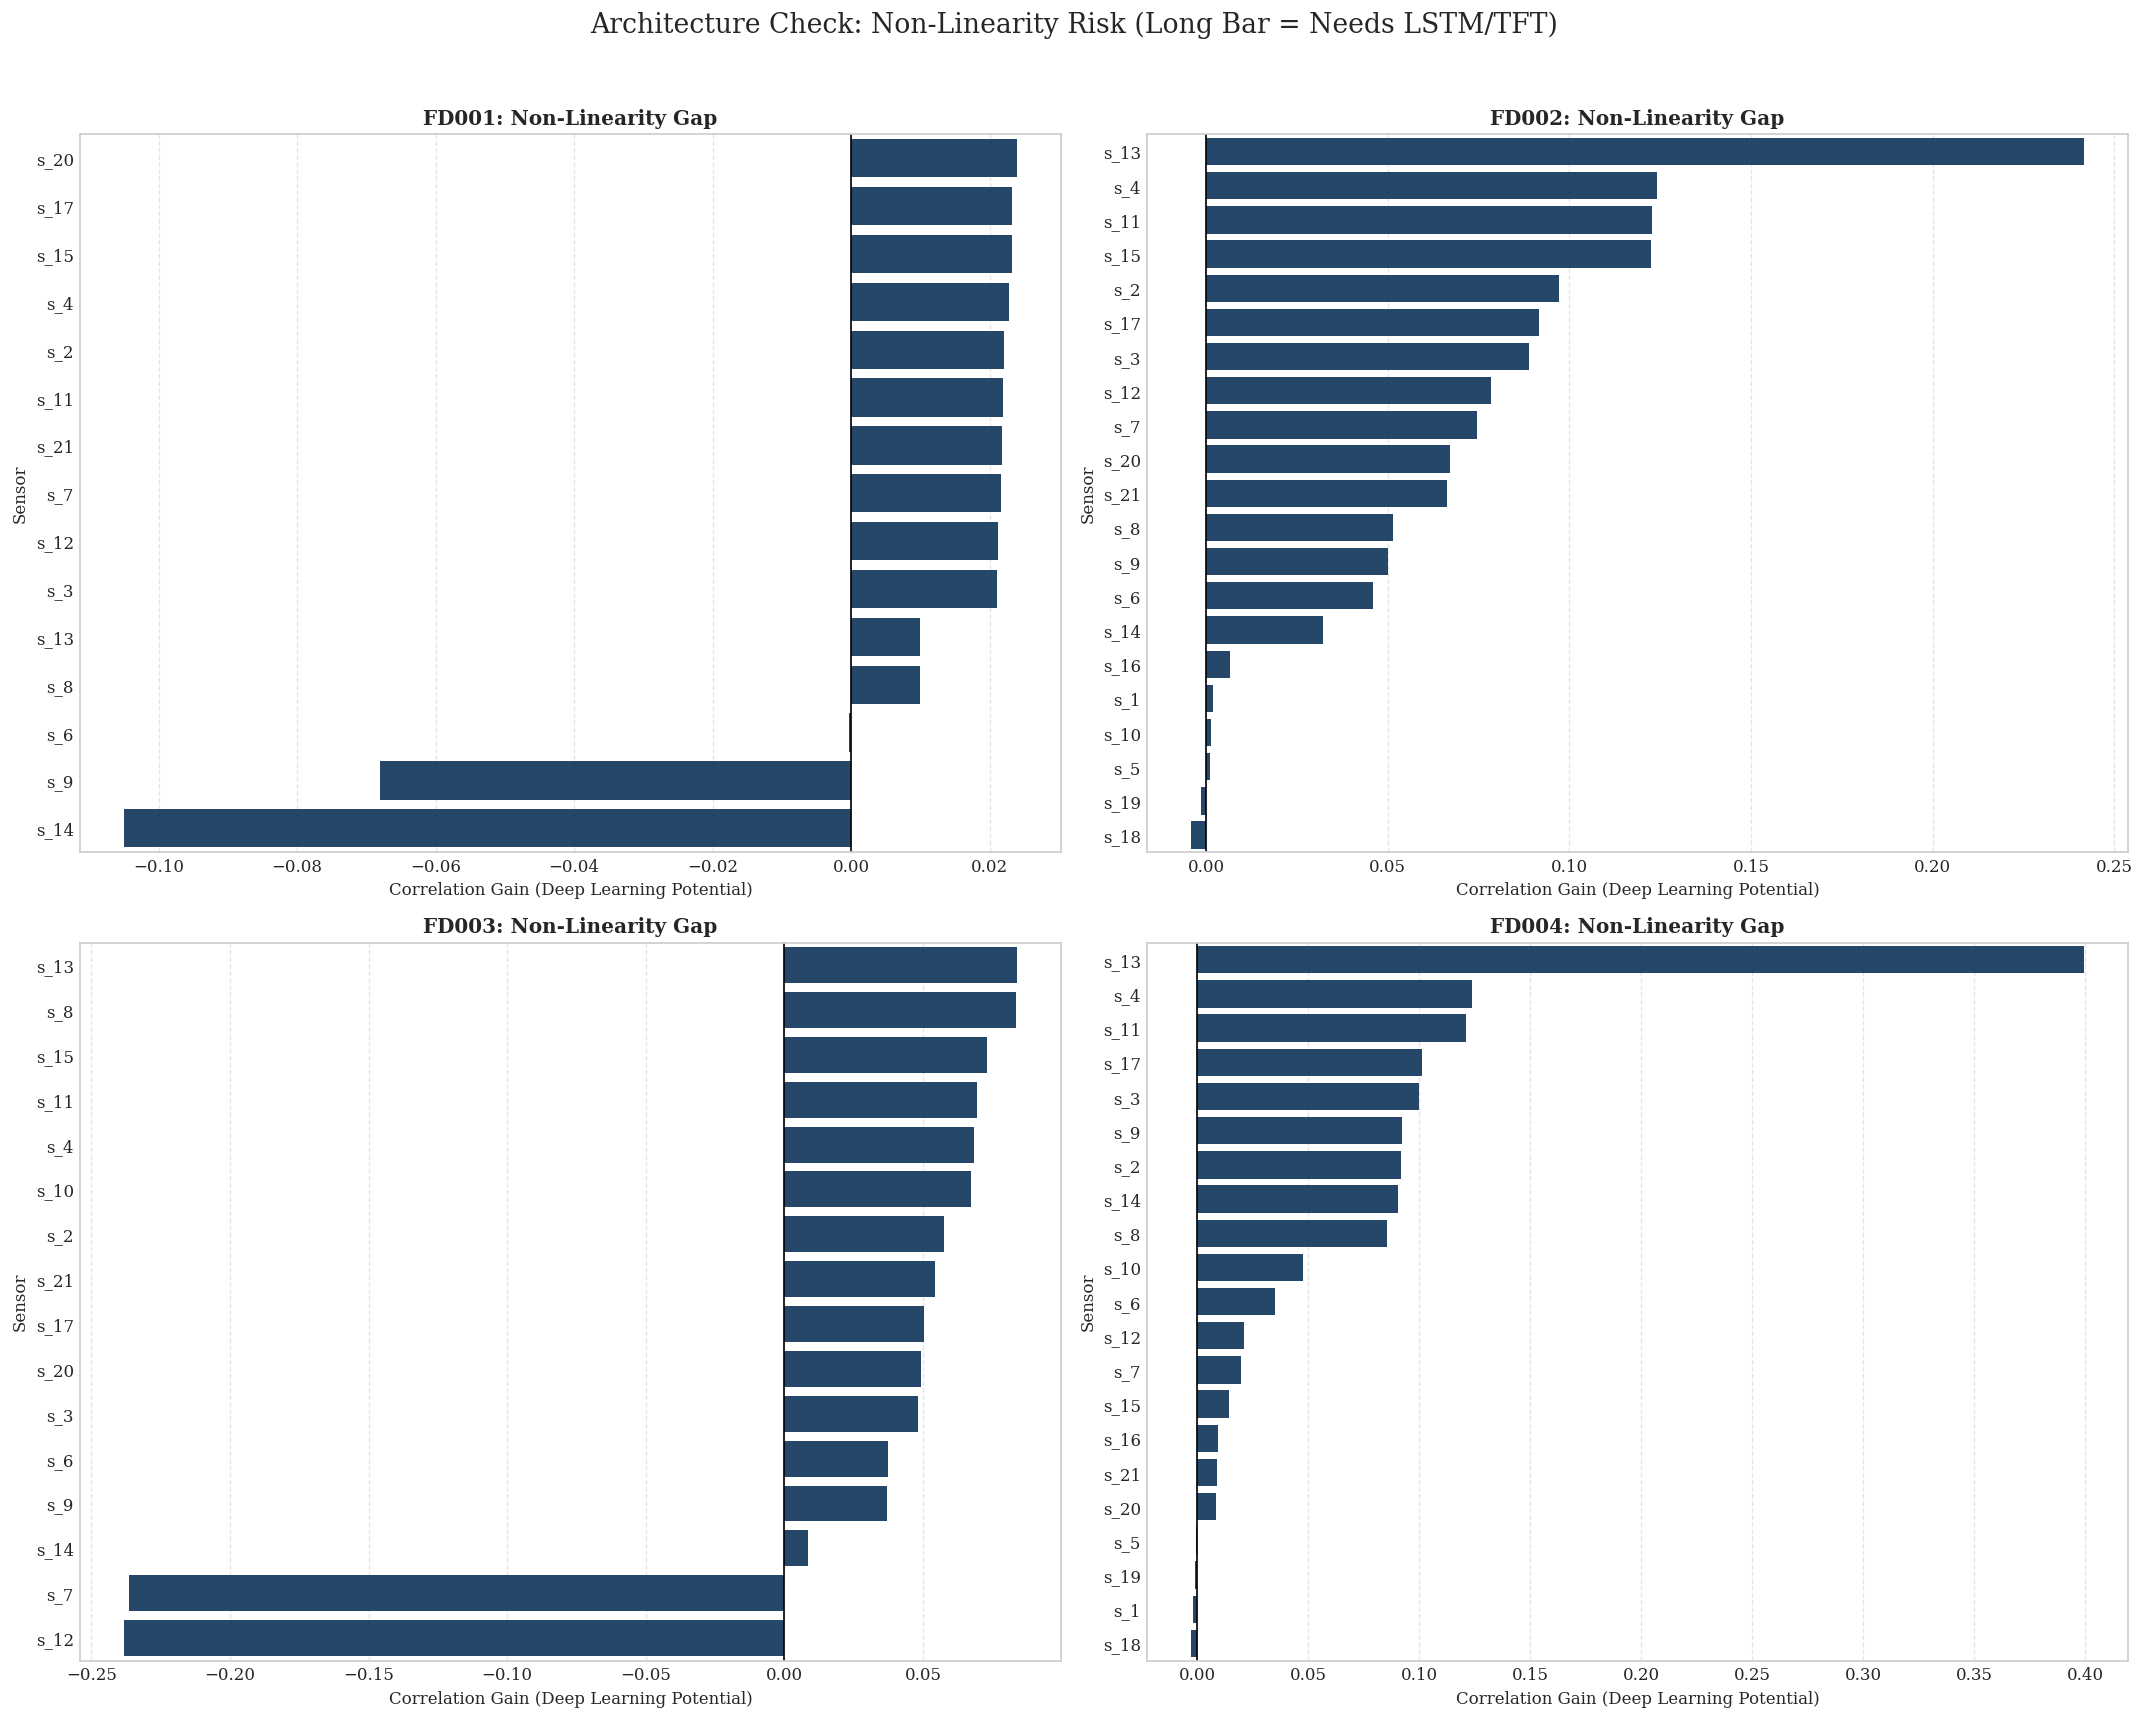

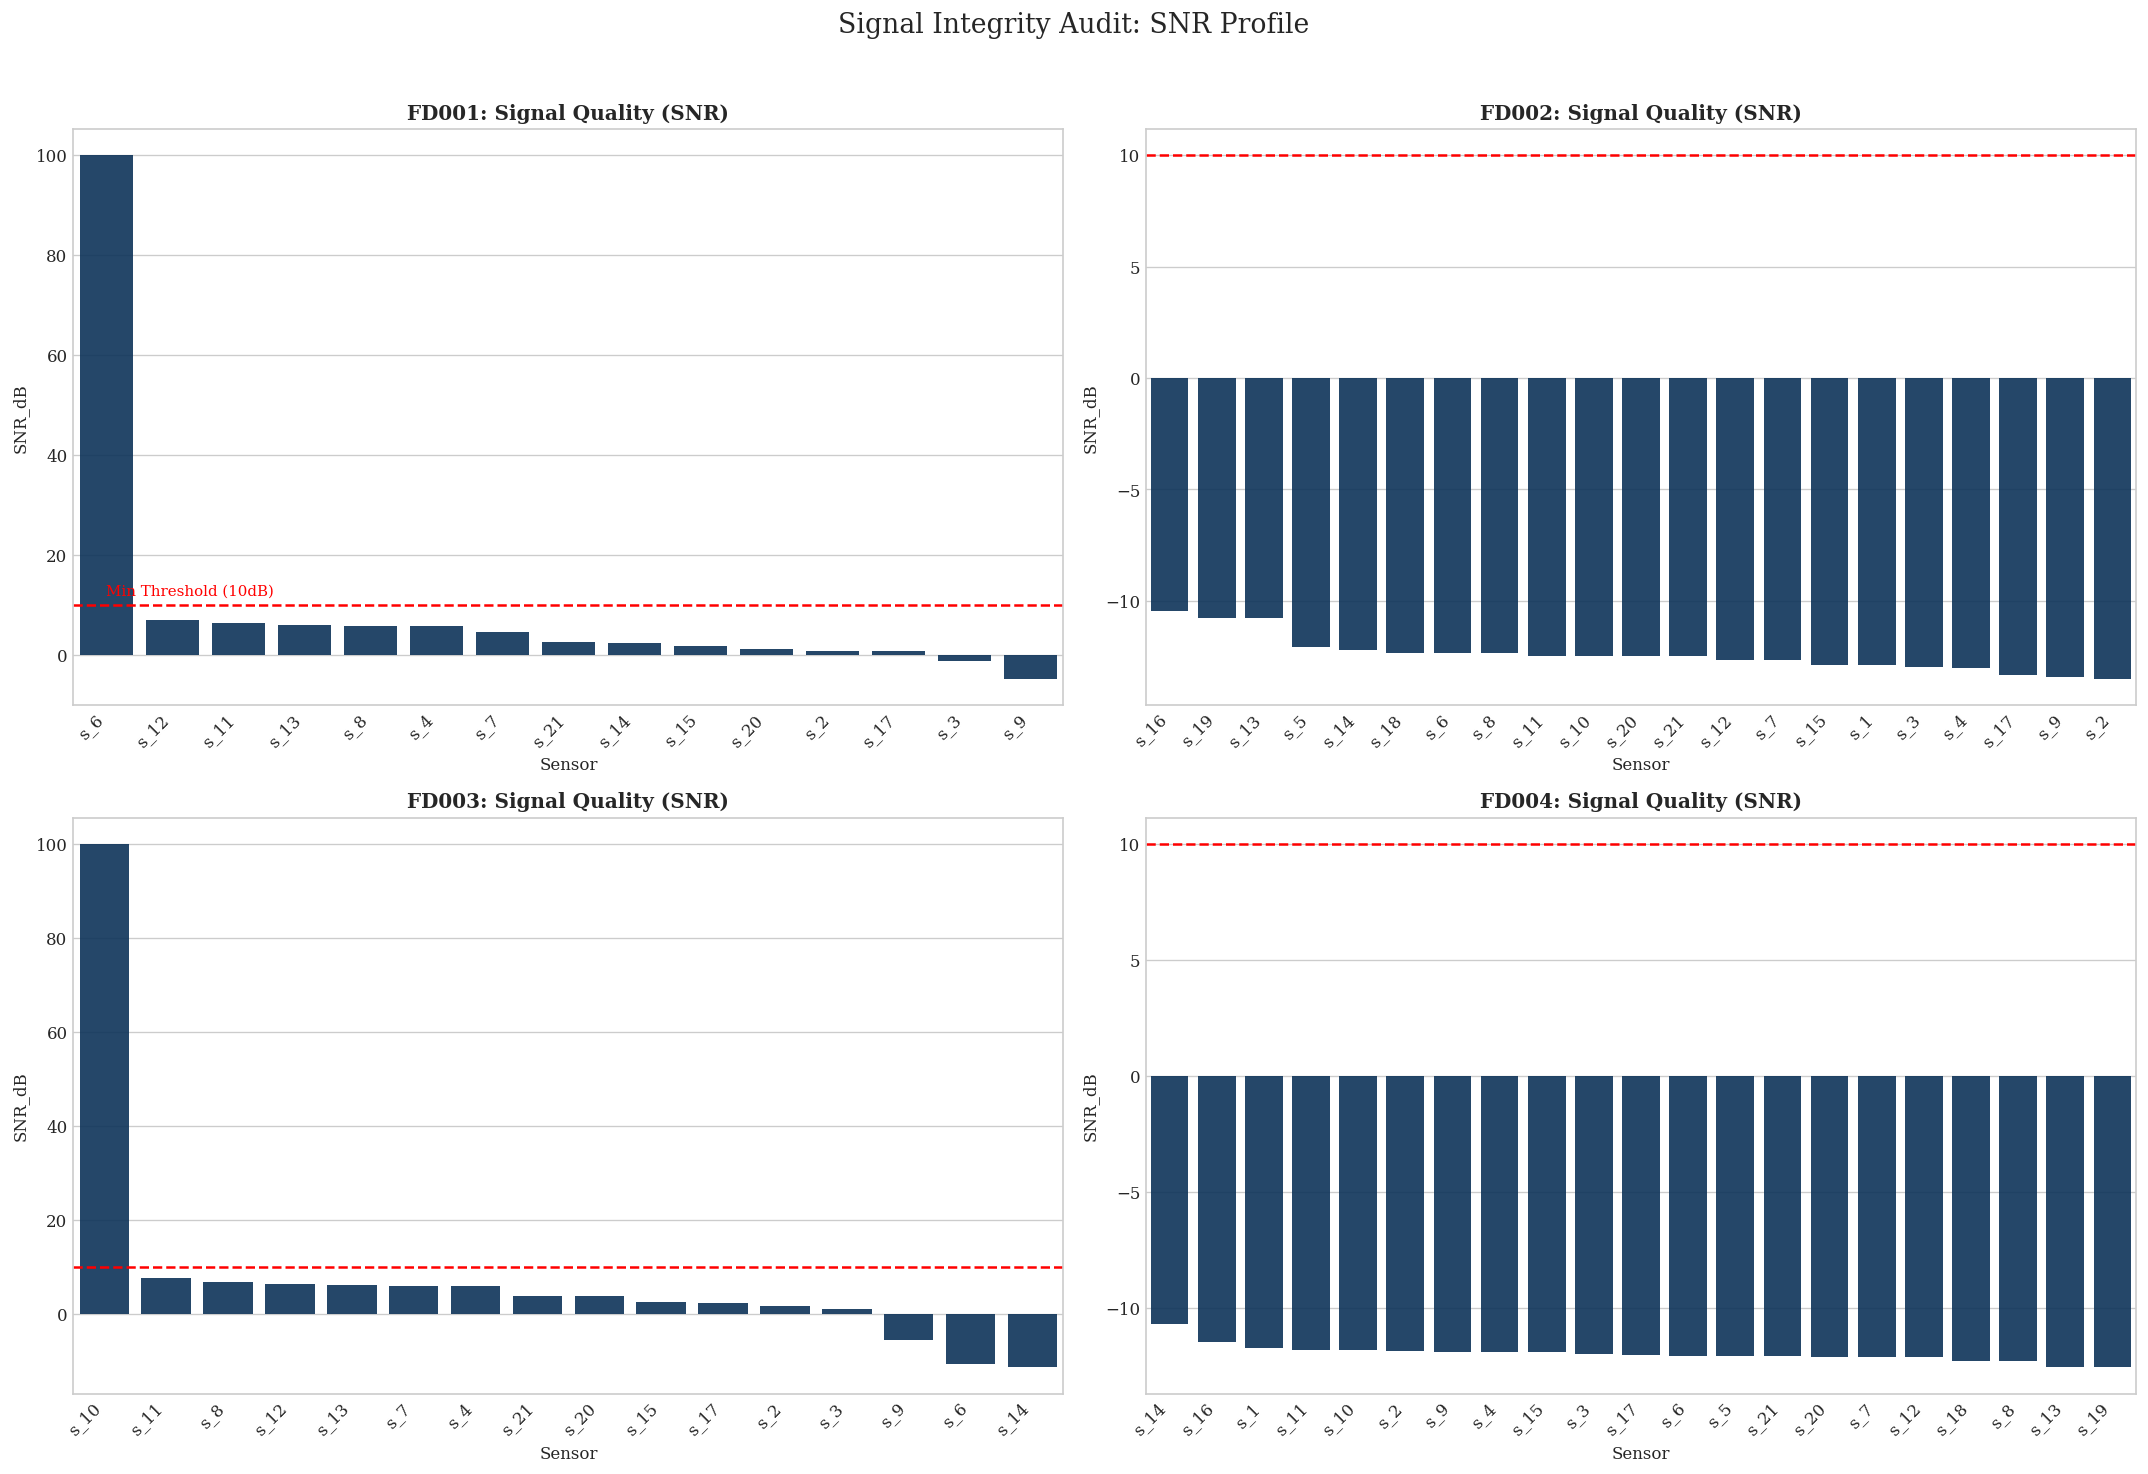

In [ ]:
# --- 5. SIGNAL QUALITY & FEATURE RANKING ---

def calculate_signal_metrics_all(data_dict):
    """
    Computes and plots Signal Quality (SNR) and Linearity Gap
    for ALL loaded datasets in a 2x2 grid.
    Uses Deep Navy Blue for a professional report style.
    """
    print("--- 📊 Comparative Signal Quality Audit ---")

    # Setup 2x2 Grids
    fig_corr, axes_corr = plt.subplots(2, 2, figsize=(18, 14))
    axes_corr = axes_corr.flatten()

    fig_snr, axes_snr = plt.subplots(2, 2, figsize=(18, 12))
    axes_snr = axes_snr.flatten()

    dataset_order = ['FD001', 'FD002', 'FD003', 'FD004']
    NAVY_BLUE = '#003366' # Professional Deep Navy

    for i, name in enumerate(dataset_order):
        if name not in data_dict:
            for ax in [axes_corr[i], axes_snr[i]]:
                ax.text(0.5, 0.5, 'Not Loaded', ha='center')
                ax.set_title(f'{name} (Missing)')
            continue

        df = data_dict[name]
        sensor_cols = [f's_{i}' for i in range(1, 22)]
        active_sensors = [s for s in sensor_cols if df[s].var() > 1e-6]

        metrics = []
        for sensor in active_sensors:
            pearson_score, _ = pearsonr(df[sensor], df['RUL'])
            spearman_score, _ = spearmanr(df[sensor], df['RUL'])
            gap = abs(spearman_score) - abs(pearson_score)

            # SNR
            unit_signal = df[df['unit_id'] == 1][sensor]
            trend = unit_signal.rolling(window=15, center=True).mean().dropna()
            noise = unit_signal.loc[trend.index] - trend
            var_noise = noise.var()
            snr_db = 100 if var_noise == 0 else 10 * np.log10(trend.var() / var_noise)

            metrics.append({'Sensor': sensor, 'Linearity_Gap': gap, 'SNR_dB': snr_db})

        metrics_df = pd.DataFrame(metrics).sort_values(by='Linearity_Gap', ascending=False)

        # --- PLOT 1: Linearity Gap (Horizontal Bar - Navy) ---
        ax = axes_corr[i]
        sns.barplot(data=metrics_df, x='Linearity_Gap', y='Sensor',
                    color=NAVY_BLUE, alpha=0.9, ax=ax)

        ax.set_title(f'{name}: Non-Linearity Gap', fontweight='bold')
        ax.set_xlabel('Correlation Gain (Deep Learning Potential)')
        ax.axvline(x=0, color='black', linewidth=1)
        ax.grid(True, axis='x', linestyle='--', alpha=0.5)

        # --- PLOT 2: SNR Bar Chart (Navy) ---
        ax2 = axes_snr[i]
        metrics_df_snr = metrics_df.sort_values(by='SNR_dB', ascending=False)
        sns.barplot(data=metrics_df_snr, x='Sensor', y='SNR_dB',
                    color=NAVY_BLUE, alpha=0.9, ax=ax2)

        ax2.set_title(f'{name}: Signal Quality (SNR)', fontweight='bold')
        ax2.axhline(y=10, color='r', linestyle='--', linewidth=1.5)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        if i == 0: ax2.text(0, 12, "Min Threshold (10dB)", color='red', fontsize=9)

    fig_corr.suptitle("Architecture Check: Non-Linearity Risk (Long Bar = Needs LSTM/TFT)", fontsize=16, y=1.02)
    fig_corr.tight_layout()

    fig_snr.suptitle("Signal Integrity Audit: SNR Profile", fontsize=16, y=1.02)
    fig_snr.tight_layout()
    plt.show()

if 'data_dict' in locals(): calculate_signal_metrics_all(data_dict)

## (6) Fleet Homogeneity Audit (Regime Coverage)

This audit answers a critical architectural question: **"Is the fleet homogeneous?"**

* We verify if every engine visits every operating regime. If coverage is partial, the model may overfit to specific "Specialist" engines.

* **Homogeneous:** Every engine experiences every operating regime (e.g., every plane flies both Take-off and Cruise).
    * *Implication:* We can train a single global model.
* **Heterogeneous:** Some engines are "Specialists" (e.g., some planes only fly short-haul/low-altitude).
    * *Implication:* A global model will under-perform on the "Specialist" engines. We may need **Cluster-Specific Models** or **Hierarchical Training**.

**Visualisation:**
* We cluster the operating settings (K=6 for Complex, K=1 for Simple).
* We count how many **unique engines** appear in each cluster.
* **Pass Criteria:** All bars must touch the "Total Fleet" line (100% coverage).

--- ✈️ Regime Population Audit (Fleet Coverage) ---


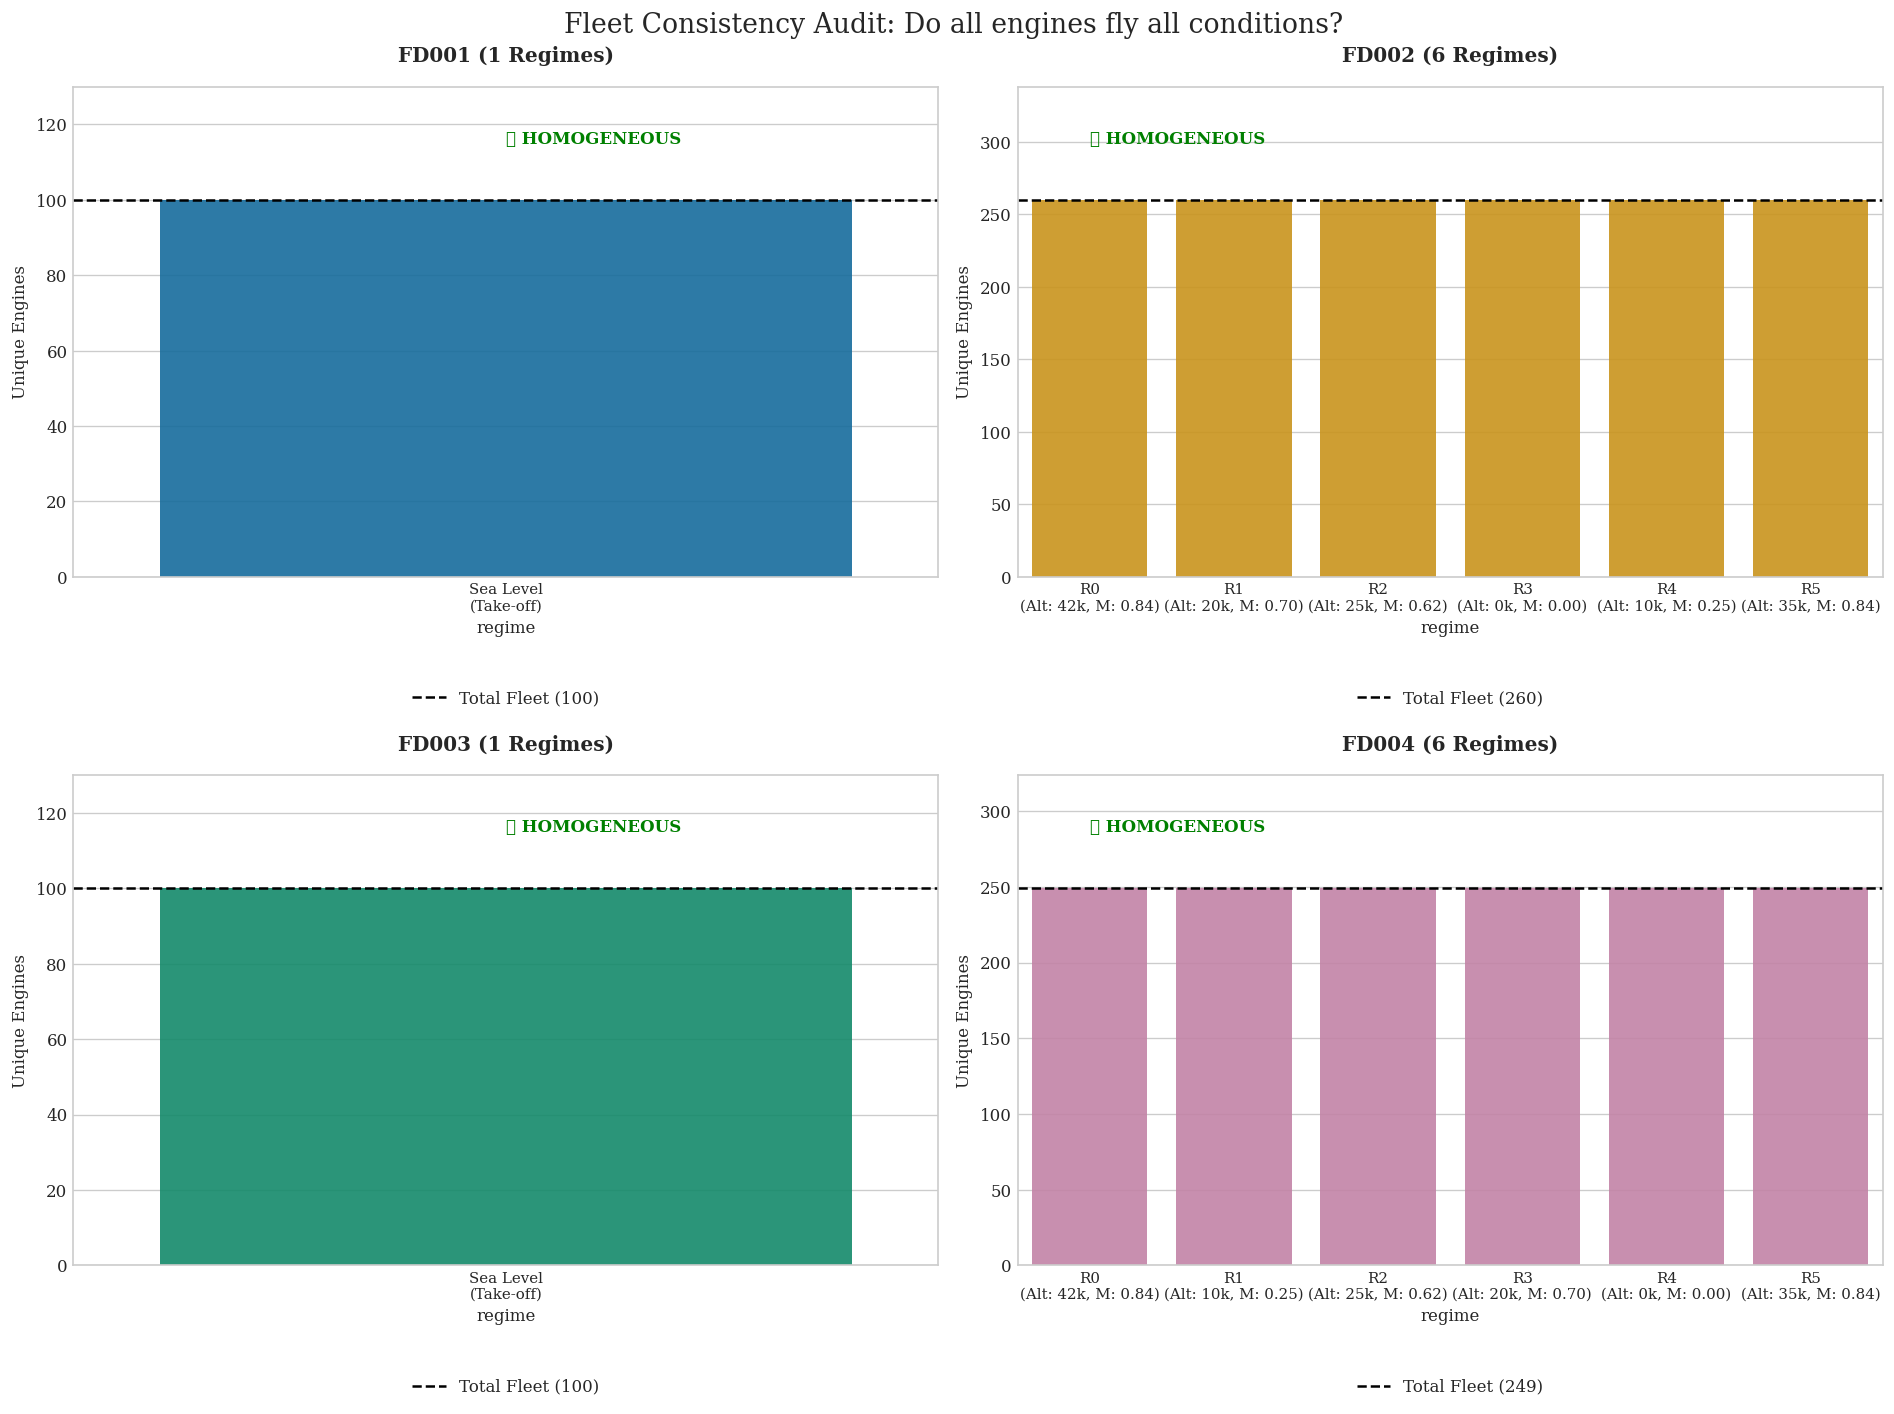

In [ ]:
# --- 6. REGIME POPULATION AUDIT ---

FusionColours = {
    'FD001': '#0072B2',  # Blue
    'FD002': '#E69F00',  # Orange
    'FD003': '#009E73',  # Green
    'FD004': '#CC79A7'   # Purple
}

def plot_regime_population(data_dict):
    """
    Diagnoses 'Fleet Homogeneity'.
    UPGRADE: Replaces 'Cluster ID' with actual Physical Labels (Altitude/Mach).
    """
    print("--- ✈️ Regime Population Audit (Fleet Coverage) ---")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Taller for x-labels
    axes = axes.flatten()
    dataset_order = ['FD001', 'FD002', 'FD003', 'FD004']

    for i, name in enumerate(dataset_order):
        if name not in data_dict:
            axes[i].text(0.5, 0.5, 'Not Loaded', ha='center')
            axes[i].set_title(f'{name} (Missing)')
            continue

        df = data_dict[name]
        total_engines = df['unit_id'].nunique()

        # --- REGIME IDENTIFICATION & LABELING ---
        if name in ['FD001', 'FD003']:
            # Single Regime Case
            regime_labels = pd.Series(0, index=df.index)
            n_clusters = 1
            x_tick_labels = ["Sea Level\n(Take-off)"]
        else:
            # Multi-Regime Case (FD002/FD004)
            kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
            regime_labels = kmeans.fit_predict(df[['setting_1', 'setting_2', 'setting_3']])
            n_clusters = 6

            # Dynamic Label Generation: "What does this cluster actually mean?"
            # We calculate mean Altitude and Mach for each cluster ID
            temp_df = df[['setting_1', 'setting_2']].copy()
            temp_df['regime'] = regime_labels
            centroids = temp_df.groupby('regime').mean().sort_index()

            x_tick_labels = []
            for idx, row in centroids.iterrows():
                # Setting 1 = Altitude (k ft), Setting 2 = Mach
                alt_k = row['setting_1']  # Value is approx 10, 20, 35 etc.
                mach = row['setting_2']
                # Create a readable string: "R0\n(Alt: 35k)"
                label = f"R{idx}\n(Alt: {alt_k:.0f}k, M: {mach:.2f})"
                x_tick_labels.append(label)

        # Count Unique Engines
        temp_df = pd.DataFrame({'unit_id': df['unit_id'], 'regime': regime_labels})
        coverage = temp_df.groupby('regime')['unit_id'].nunique()

        # Plot
        target_colour = FusionColours.get(name, 'gray')
        sns.barplot(x=coverage.index, y=coverage.values, ax=axes[i], color=target_colour, alpha=0.9)

        # Reference Line
        axes[i].axhline(y=total_engines, color='black', linestyle='--', linewidth=1.5, label=f'Total Fleet ({total_engines})')

        # Styling
        axes[i].set_title(f'{name} ({n_clusters} Regimes)', fontweight='bold', pad=15)
        axes[i].set_ylabel('Unique Engines')

        # Apply the Physical Labels
        axes[i].set_xticklabels(x_tick_labels, rotation=0, fontsize=9)

        # Fix Layout (Headroom + Legend)
        axes[i].set_ylim(0, total_engines * 1.3)
        axes[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                       frameon=False, ncol=1, fontsize=10)

        # Risk Annotation
        if coverage.min() < total_engines:
            axes[i].text(0, total_engines * 1.15, "⚠️ HETEROGENEOUS", color='red', fontweight='bold')
        else:
             axes[i].text(0, total_engines * 1.15, "✅ HOMOGENEOUS", color='green', fontweight='bold')

    plt.suptitle("Fleet Consistency Audit: Do all engines fly all conditions?", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

if 'data_dict' in locals(): plot_regime_population(data_dict)

## (7) Signal Latency & Prognostic Horizon

This section answers the critical logistics question: **"How much warning time do we get?"**

We audit **every active sensor** to identify the "Prognostic Gap"—sensors that are physically important but statistically late to react.

### 📋 Sensor Reference Table

| Sensor ID | Physical Description | Location | Units | Critical Failure Mode |
| :--- | :--- | :--- | :--- | :--- |
| **s_2** | T24 Total Temp | LPC Outlet | °R | Fan/LPC Degradation |
| **s_3** | T30 Total Temp | HPC Outlet | °R | HPC Efficiency Loss |
| **s_4** | T50 Total Temp | LPT Outlet | °R | **EGT (Primary Health Indicator)** |
| **s_6** | P15 Total Pressure | Bypass Duct | psia | Fan Efficiency |
| **s_7** | P30 Total Pressure | HPC Outlet | psia | Compression Ratio Loss |
| **s_8** | Nf Physical Speed | Fan | rpm | Shaft Imbalance |
| **s_9** | Nc Physical Speed | Core | rpm | Core Speed Shift |
| **s_11** | P50 Total Pressure | LPT Outlet | psia | Turbine Efficiency |
| **s_12** | Phi (Ratio) | Fan Inlet | - | Fan Stall Margin |
| **s_13** | NRf Corrected Speed | Fan | rpm | **Primary Fan Indicator** |
| **s_14** | NRc Corrected Speed | Core | rpm | **Primary Core Indicator** |
| **s_15** | BPR (Bypass Ratio) | Duct | - | Flow Divergence |
| **s_17** | HPT Coolant Bleed | HPT | lbm/s | Thermal Management |
| **s_20** | HPT Coolant Bleed | LPT | lbm/s | Thermal Management |
| **s_21** | LPT Coolant Bleed | LPT | lbm/s | Thermal Management |

*Note: Sensors s_1, s_5, s_10, s_16, s_18, and s_19 are typically excluded as "Dead Sensors" (constant output).*

--- ⏱️ Comparative Prognostic Horizon Audit (Full Fleet) ---


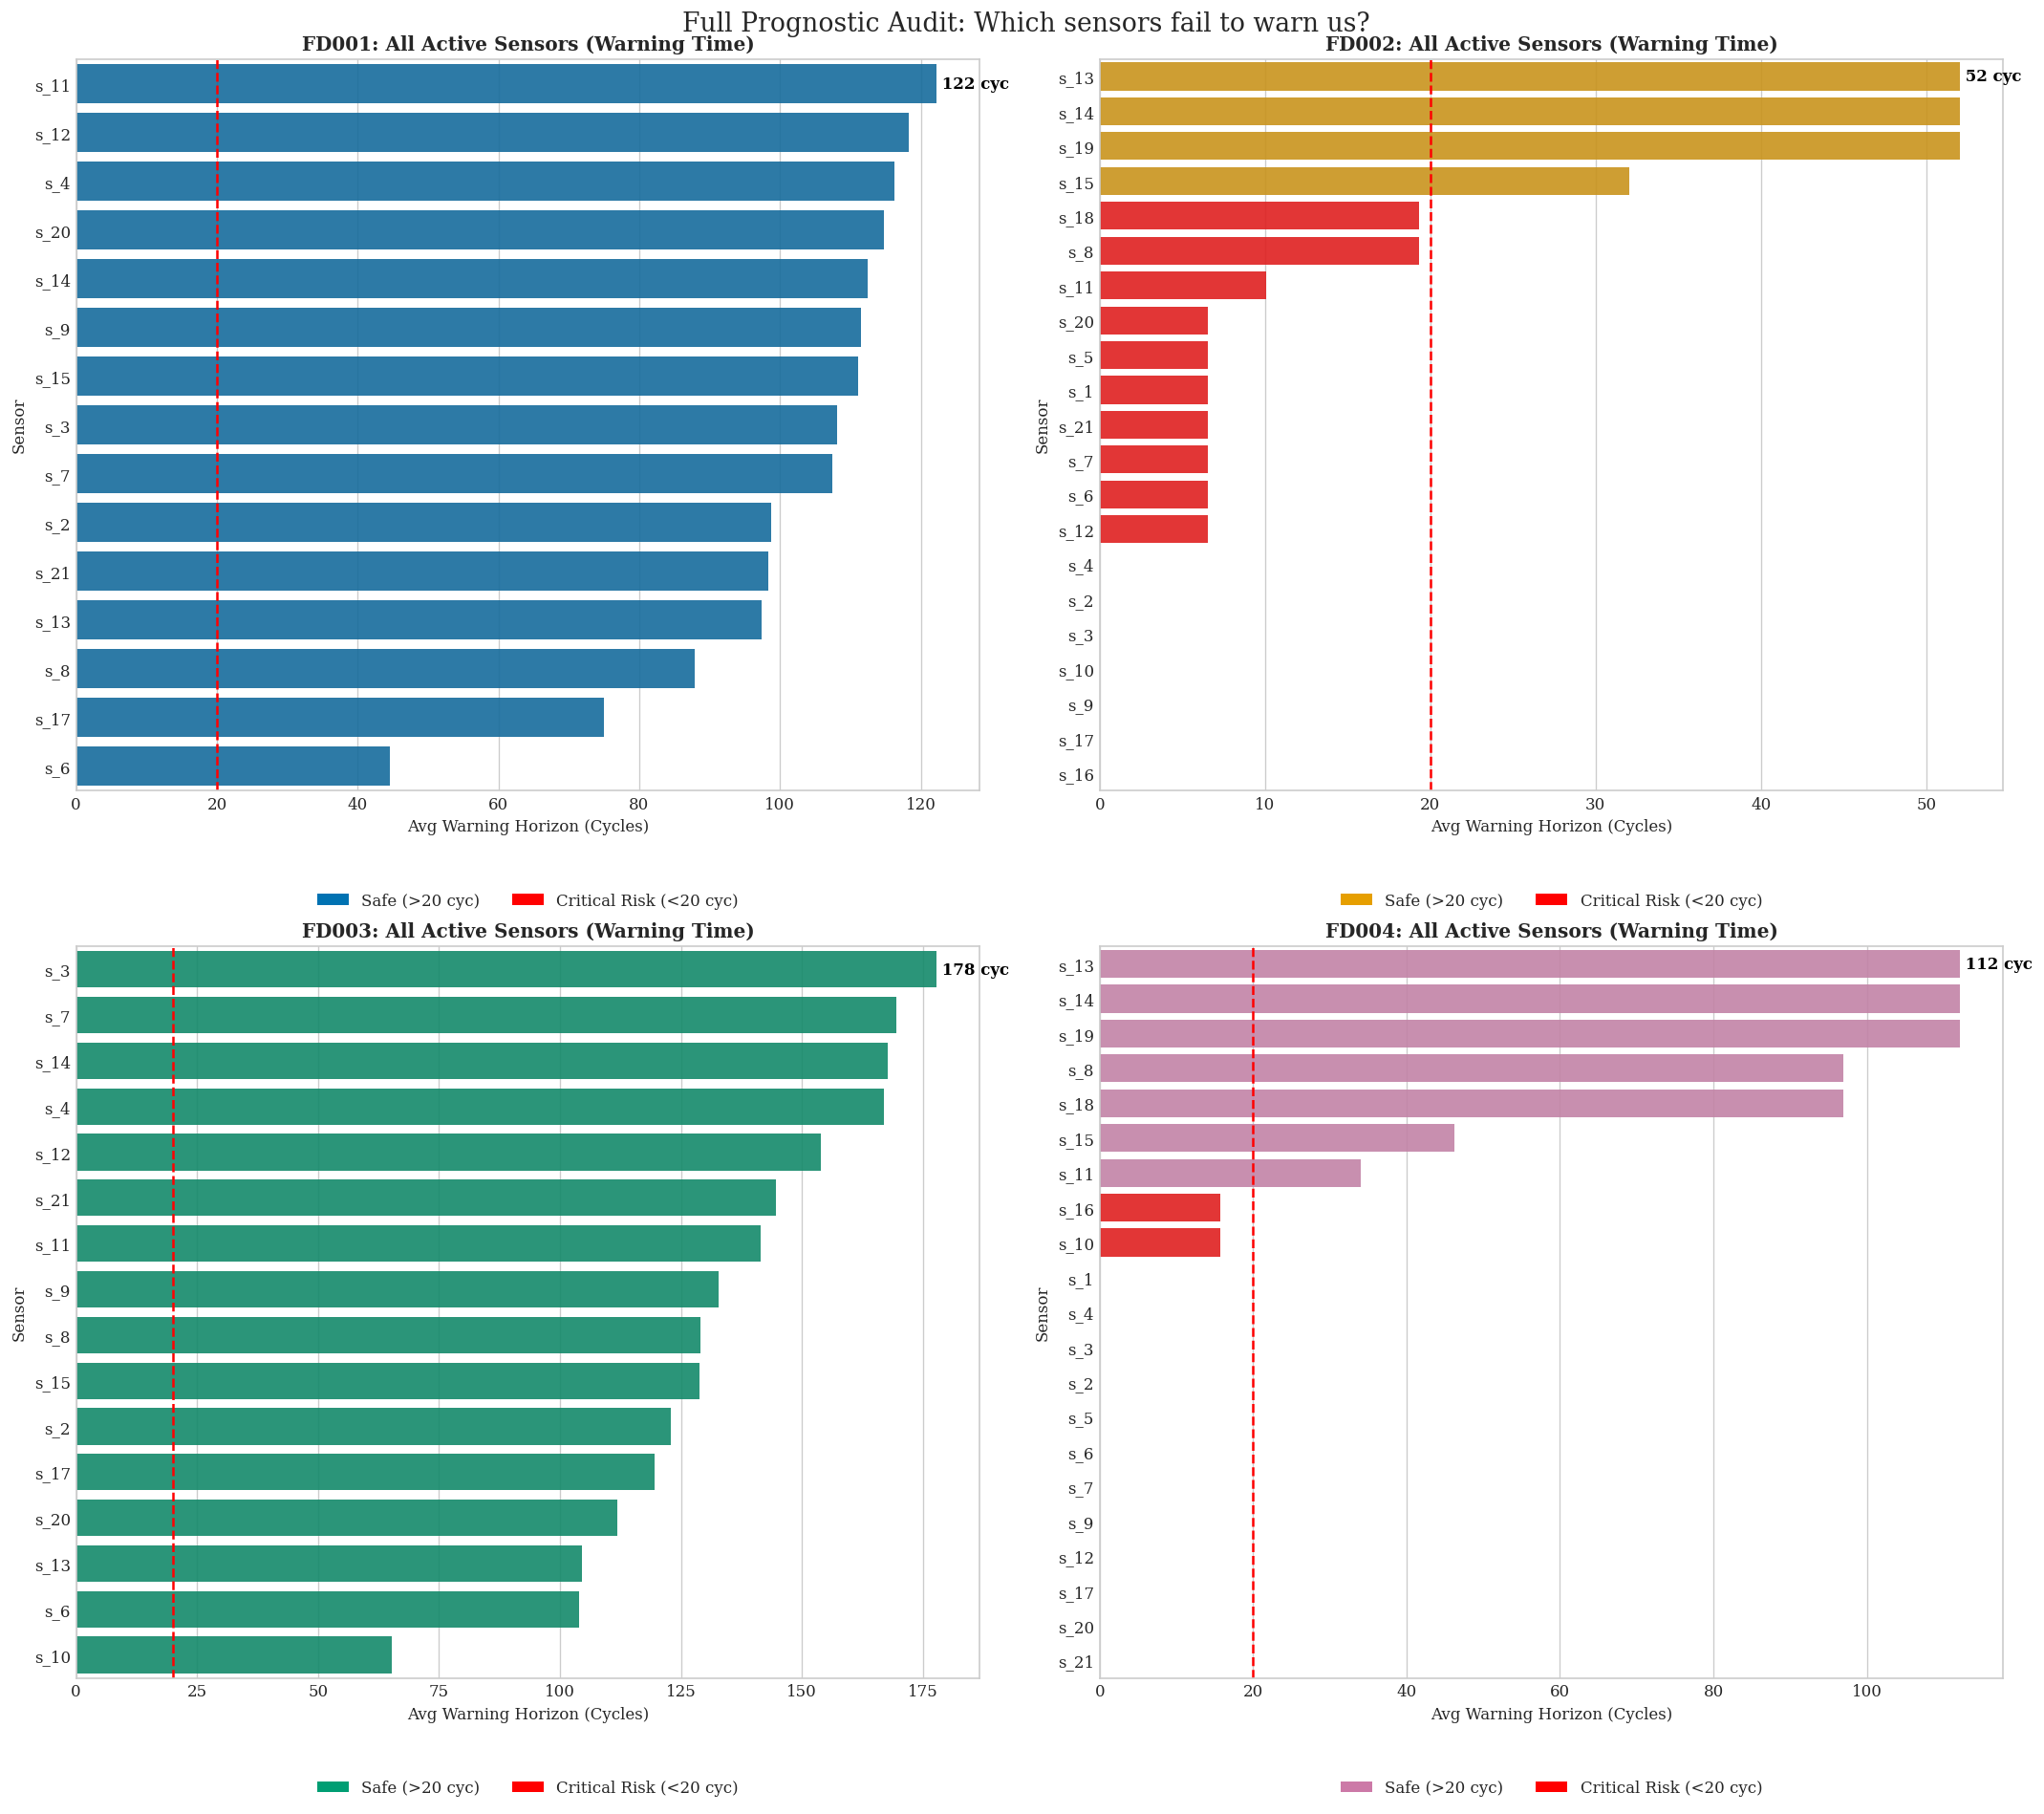

In [ ]:
# --- 7. SIGNAL LATENCY & PROGNOSTIC HORIZON ---

def analyze_prognostic_horizon_all(data_dict):
    """
    Calculates 'Warning Time' (Prognostic Horizon) for ALL active sensors.
    RISK HIGHLIGHTING:
    - Safe Sensors (>20 cyc): Use Dataset's FusionColour.
    - Critical Risk (<20 cyc): Highlight in Red.
    """
    print("--- ⏱️ Comparative Prognostic Horizon Audit (Full Fleet) ---")

    FusionColours = {
        'FD001': '#0072B2',  # Blue
        'FD002': '#E69F00',  # Orange
        'FD003': '#009E73',  # Green
        'FD004': '#CC79A7'   # Purple
    }

    # Increased height to fit all sensors comfortably
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    axes = axes.flatten()
    dataset_order = ['FD001', 'FD002', 'FD003', 'FD004']

    for i, name in enumerate(dataset_order):
        if name not in data_dict:
            axes[i].text(0.5, 0.5, 'Not Loaded', ha='center')
            axes[i].set_title(f'{name} (Missing)')
            continue

        df = data_dict[name]
        sensor_cols = [f's_{i}' for i in range(1, 22)]

        # Filter active sensors (Variance > threshold)
        active_sensors = [s for s in sensor_cols if df[s].var() > 1e-6]

        horizon_results = []
        # Sample first 20 units for speed (statistically representative)
        sample_units = df['unit_id'].unique()[:20]

        for sensor in active_sensors:
            warning_times = []
            for unit in sample_units:
                subset = df[df['unit_id'] == unit].sort_values('time_cycle')
                max_life = subset['time_cycle'].max()

                # 1. Establish Baseline (First 15 cycles)
                baseline_window = subset.iloc[:15]
                mean = baseline_window[sensor].mean()
                std = baseline_window[sensor].std()

                # Threshold: 3 Sigma Divergence
                upper = mean + 3 * std
                lower = mean - 3 * std

                # 2. Find Breach Point
                breaches = subset[(subset[sensor] > upper) | (subset[sensor] < lower)]

                if not breaches.empty:
                    first_breach = breaches['time_cycle'].iloc[0]
                    warning_time = max_life - first_breach
                    warning_times.append(warning_time)
                else:
                    warning_times.append(0)

            avg_warning = np.mean(warning_times)
            horizon_results.append({'Sensor': sensor, 'Avg_Warning_Cycles': avg_warning})

        # SHOW ALL SENSORS (Sorted by Warning Time)
        horizon_df = pd.DataFrame(horizon_results).sort_values(by='Avg_Warning_Cycles', ascending=False)

        # --- COLOUR LOGIC ---
        base_colour = FusionColours.get(name, 'gray')
        # Red if < 20 cycles, Base Colour otherwise
        bar_colours = ['red' if x < 20 else base_colour for x in horizon_df['Avg_Warning_Cycles']]

        # --- PLOT ---
        sns.barplot(data=horizon_df, x='Avg_Warning_Cycles', y='Sensor',
                    palette=bar_colours, ax=axes[i], alpha=0.9)

        axes[i].set_title(f'{name}: All Active Sensors (Warning Time)', fontweight='bold')
        axes[i].set_xlabel('Avg Warning Horizon (Cycles)')

        # Safety Threshold Line
        axes[i].axvline(x=20, color='red', linestyle='--', linewidth=1.5, label='Min Safety (20 Cyc)')

        # Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=base_colour, label='Safe (>20 cyc)'),
            Patch(facecolor='red', label='Critical Risk (<20 cyc)')
        ]
        axes[i].legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.12),
                       frameon=False, ncol=2, fontsize=10)

        # Annotation for Best Sensor (Top 1 only to avoid clutter)
        if not horizon_df.empty:
            best_sensor = horizon_df.iloc[0]
            axes[i].text(best_sensor['Avg_Warning_Cycles'], 0, f" {best_sensor['Avg_Warning_Cycles']:.0f} cyc",
                         va='center', fontweight='bold', color='black')

    plt.suptitle("Full Prognostic Audit: Which sensors fail to warn us?", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Execute
if 'data_dict' in locals():
    analyze_prognostic_horizon_all(data_dict)

## (8) Executive Summary & Findings Log

This initial diagnostic phase (`EDA 01`) was designed to audit the structural, mathematical, and physical integrity of the C-MAPSS dataset. We have confirmed that the dataset is **highly heterogeneous**, requiring specific architectural interventions (Sequence Models, Regime Normalisation, and Attention Mechanisms).

### 📋 Key Findings & Architectural Implication Table

| Risk Category | Finding | Evidence Location | Architectural Action Required |
| :--- | :--- | :--- | :--- |
| **Data Integrity** | **Dead Sensors**: Sensors `s_1`, `s_5`, `s_10`, `s_16`, `s_18`, `s_19` are constant (Variance $\approx$ 0) across all regimes. | **Section 3:** Structural Audit (Sensor Variance Profile) | **Drop Feature:** Exclude these columns from training to reduce noise and compute. |
| **Signal Physics** | **Regime Masking**: Operating conditions (Altitude/Mach) create massive offsets that hide degradation. The "Green vs Blue" audit proves this noise is strictly additive/regime-dependent. | **Section 4A:** Regime Masking Audit (4x2 Forensic Grid) | **Regime-Specific Scaler:** Standard MinMax is forbidden. We must normalize by subtracting the **Regime Mean** (tabulated in Sec 4A). |
| **Trajectory Consistency** | **Chaotic Degradation**: Raw sensor trajectories (e.g., `s_12`) appear chaotic in FD002/FD004 due to regime switching, but underlying trends are consistent once de-noised. | **Section 4B:** Trajectory Consistency (Spaghetti Plot) | **Filtering:** Apply exponential smoothing or Kalman Filtering during preprocessing to stabilize the trend. |
| **Failure Distribution** | **Right-Skewed Survival**: Most engines fail around 200 cycles, but outliers exist (some fail early at <130, some late >350). | **Section 3:** Structural Audit (Lifecycle Box Plots) | **Loss Function:** Use a robust loss function (e.g., Huber or Quantile) to handle survival outliers. |
| **Signal Quality** | **Non-Linear Degradation**: Spearman correlation (Rank) is significantly higher than Pearson (Linear) for critical sensors (e.g., `s_4`, `s_11`). | **Section 5:** Signal Quality Audit (Linearity Gap Bar Chart) | **Model Choice:** Deep Learning (LSTM/TFT) is strictly required; Linear Regression will underfit. |
| **Prognostic Horizon** | **Variable Warning Time**: FD001 provides >60 cycles of warning. FD002 sensors often warn <20 cycles before failure (Red Zone). | **Section 7:** Prognostic Horizon Audit (Full Audit Bar Chart) | **Window Size:** Sequence length must be long enough to capture subtle early shifts (e.g., window=30+). |
| **Fleet Homogeneity** | **Homogeneous Coverage**: All engines in the fleet experience all operating regimes (100% coverage). | **Section 6:** Fleet Homogeneity Audit (Bar Chart) | **Sampling:** Random sampling is safe; no need for stratified sampling by regime. |

### 🚀 Next Steps (Transition to `EDA 02`)

With the **Diagnostics** complete, the "Smoking Gun" has been identified: **Regime Masking**.
The visual evidence in **Section 4A** proves that we can mathematically decouple the "Operating Condition" from the "Engine Health."

**Proceed to Notebook:** `02_EDA_Regimes.ipynb`